---
title: "🗓️ Week 11 - The consequences of data poisoning attacks on classification models"
subtitle: "Theme: Applications"
author: "Dr. Ghita Berrada"
format: 
  html:
    from: markdown+emoji
    page-layout: full
    toc: true
    toc-depth: 2
self-contained: true
jupyter: python3
engine: jupyter
---

Welcome to Week 11 (i.e the last formal week of teaching for this course)!

Until now, we'd worked with the assumption that the data we had to do our modeling was (mostly) reliable. But, what if that wasn't the case? What if an adversary deliberately manipulated our training data to mislead our models? In this lecture, we will explore the concept of data poisoning, a type of adversarial attack that corrupts the training data to degrade model performance or cause specific misclassifications. We will analyze how different classification models respond to such attacks and discuss possible defense strategies.

The topic of today's lecture was largely inspired by [(Yerlikaya et al. 2022)](https://doi.org/10.1016/j.eswa.2022.118101)^[Fahri Anıl Yerlikaya, Şerif Bahtiyar, Data poisoning attacks against machine learning algorithms, Expert Systems with Applications, Volume 208, 2022, 118101, ISSN 0957-4174,https://doi.org/10.1016/j.eswa.2022.118101], [(Wen et al. 2020)](https://doi.org/10.1007/978-3-030-55304-3_23)^[Wen, J., Zhao, B.Z.H., Xue, M., Qian, H. (2020). PALOR: Poisoning Attacks Against Logistic Regression. In: Liu, J., Cui, H. (eds) Information Security and Privacy. ACISP 2020. Lecture Notes in Computer Science(), vol 12248. Springer, Cham. https://doi.org/10.1007/978-3-030-55304-3_23], [(Maabreh et al. 2022)](https://journals.sagepub.com/doi/10.1177/15501329221105159)^[Maabreh M, Maabreh A, Qolomany B, Al-Fuqaha A. The robustness of popular multiclass machine learning models against poisoning attacks: Lessons and insights. International Journal of Distributed Sensor Networks. 2022;18(7). doi:10.1177/15501329221105159] as well as [(Paladini et al. 2023)](https://doi.org/10.1145/3613244)^[Tommaso Paladini, Francesco Monti, Mario Polino, Michele Carminati, and Stefano Zanero. 2023. Fraud Detection under Siege: Practical Poisoning Attacks and Defense Strategies. ACM Trans. Priv. Secur. 26, 4, Article 45 (November 2023), 35 pages. https://doi.org/10.1145/3613244].

**⚙️ A bit of setup before starting**

As usual, let's load the libraries we'll need throughout this notebook before proceeding.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,average_precision_score,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import missingno as msno
import sweetviz as sv
from lets_plot import *
LetsPlot.setup_html()

## 📊 Part 1: Introducing the data

The dataset we'll test things on today contains information on individuals applying for credit, with a target variable (`Credit_Risk`) indicating whether they are a good (1) or bad (0) credit risk. This data is publicly available in the [UCI Machine Learning repository](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data).

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Load German Credit dataset
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", 
                 delimiter=' ', header=None)
# Assign column names based on dataset description
df.columns = [
    "Status", "Duration", "Credit_History", "Purpose", "Credit_Amount", "Savings", "Employment", "Installment_Rate",
    "Personal_Status", "Other_Debtors", "Residence_Years", "Property", "Age", "Other_Installments", "Housing",
    "Existing_Credits", "Job", "Liable_People", "Telephone", "Foreign_Worker", "Credit_Risk"
]

# Convert target variable to binary (1 = Good Credit, 0 = Bad Credit)
df['Credit_Risk'] = df['Credit_Risk'].map({1: 1, 2: 0})

# Display dataset info and first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (1000, 21)


Status  Duration Credit_History Purpose  Credit_Amount Savings Employment  \
0    A11         6            A34     A43           1169     A65        A75   
1    A12        48            A32     A43           5951     A61        A73   
2    A14        12            A34     A46           2096     A61        A74   
3    A11        42            A32     A42           7882     A61        A74   
4    A11        24            A33     A40           4870     A61        A73   

   Installment_Rate Personal_Status Other_Debtors  ...  Property Age  \
0                 4             A93          A101  ...      A121  67   
1                 2             A92          A101  ...      A121  22   
2                 2             A93          A101  ...      A121  49   
3                 2             A93          A103  ...      A122  45   
4                 3             A93          A101  ...      A124  53   

   Other_Installments Housing Existing_Credits   Job Liable_People  Telephone  \
0                A143    A152                2  A173             1       A192   
1                A143    A152                1  A173             1       A191   
2                A143    A152                1  A172             2       A191   
3                A143    A153                1  A173             2       A191   
4                A143    A153                2  A173             2       A191   

  Foreign_Worker Credit_Risk  
0           A201           1  
1           A201           0  
2           A201           1  
3           A201           1  
4           A201           0  

[5 rows x 21 columns]

We create a feature dictionary for later explainability purposes (based on explanations of the values of each feature provided on the [UCI page where the data is made available](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data))

In [5]:
# Feature Dictionary for Explainability
feature_dict = {
    "Status": {"A11": "< 0 DM", "A12": "0 <= ... < 200 DM", "A13": ">= 200 DM / salary assignments", "A14": "No checking account"},
    "Credit_History": {"A30": "No credits taken / all paid back duly", "A31": "All credits at this bank paid back duly",
                        "A32": "Existing credits paid back duly", "A33": "Delay in paying off", "A34": "Critical account"},
    "Purpose": {"A40": "Car (new)", "A41": "Car (used)", "A42": "Furniture/equipment", "A43": "Radio/TV",
                 "A44": "Domestic appliances", "A45": "Repairs", "A46": "Education", "A47": "Vacation (not in dataset)",
                 "A48": "Retraining", "A49": "Business", "A410": "Others"},
    "Savings": {"A61": "< 100 DM", "A62": "100 <= ... < 500 DM", "A63": "500 <= ... < 1000 DM", "A64": ">= 1000 DM",
                 "A65": "Unknown / No savings account"},
    "Employment": {"A71": "Unemployed", "A72": "< 1 year", "A73": "1 <= ... < 4 years", "A74": "4 <= ... < 7 years",
                    "A75": ">= 7 years"},
    "Personal_Status": {"A91": "Male: Divorced/Separated", "A92": "Female: Divorced/Separated/Married", "A93": "Male: Single",
                         "A94": "Male: Married/Widowed", "A95": "Female: Single"},
    "Other_Debtors": {"A101": "None", "A102": "Co-applicant", "A103": "Guarantor"},
    "Property": {"A121": "Real estate", "A122": "Savings/Life insurance", "A123": "Car or other property", "A124": "Unknown"},
    "Other_Installments": {"A141": "Bank", "A142": "Stores", "A143": "None"},
    "Housing": {"A151": "Rent", "A152": "Own", "A153": "For free"},
    "Job": {"A171": "Unemployed/Unskilled (Non-resident)", "A172": "Unskilled (Resident)", "A173": "Skilled Employee/Official",
             "A174": "Management/Self-employed/Highly qualified"},
    "Telephone": {"A191": "None", "A192": "Yes, registered"},
    "Foreign_Worker": {"A201": "Yes", "A202": "No"}
}

Here is a brief summary of the features in the data:

| Feature | Description |
|---------|-------------|
| Status | Status of existing checking account |
| Duration | Duration in months |
| Credit_History | Credit history of the applicant |
| Purpose | Purpose of the credit |
| Credit_Amount | Credit amount in DM |
| Savings | Savings account/bonds |
| Employment | Present employment since |
| Installment_Rate | Installment rate in percentage of disposable income |
| Personal_Status | Personal status and sex |
| Other_Debtors | Other debtors/guarantors |
| Residence_Years | Present residence since (years) |
| Property | Property ownership status |
| Age | Age in years |
| Other_Installments | Other installment plans |
| Housing | Housing situation |
| Existing_Credits | Number of existing credits at this bank |
| Job | Job type |
| Liable_People | Number of people being liable for maintenance |
| Telephone | Telephone ownership |
| Foreign_Worker | Whether the applicant is a foreign worker |

                                             |          | [  0%]   00:00 -> (? left)


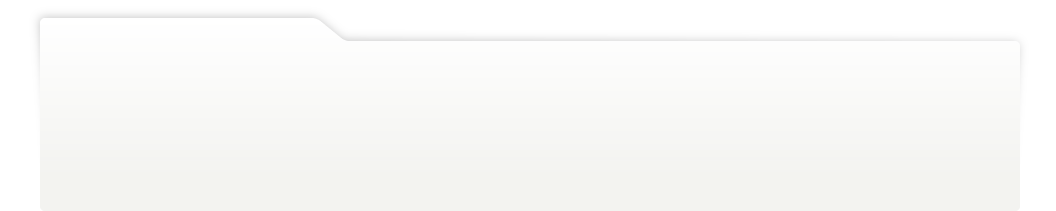
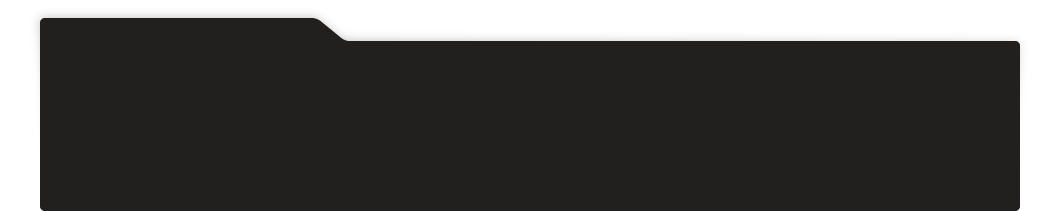
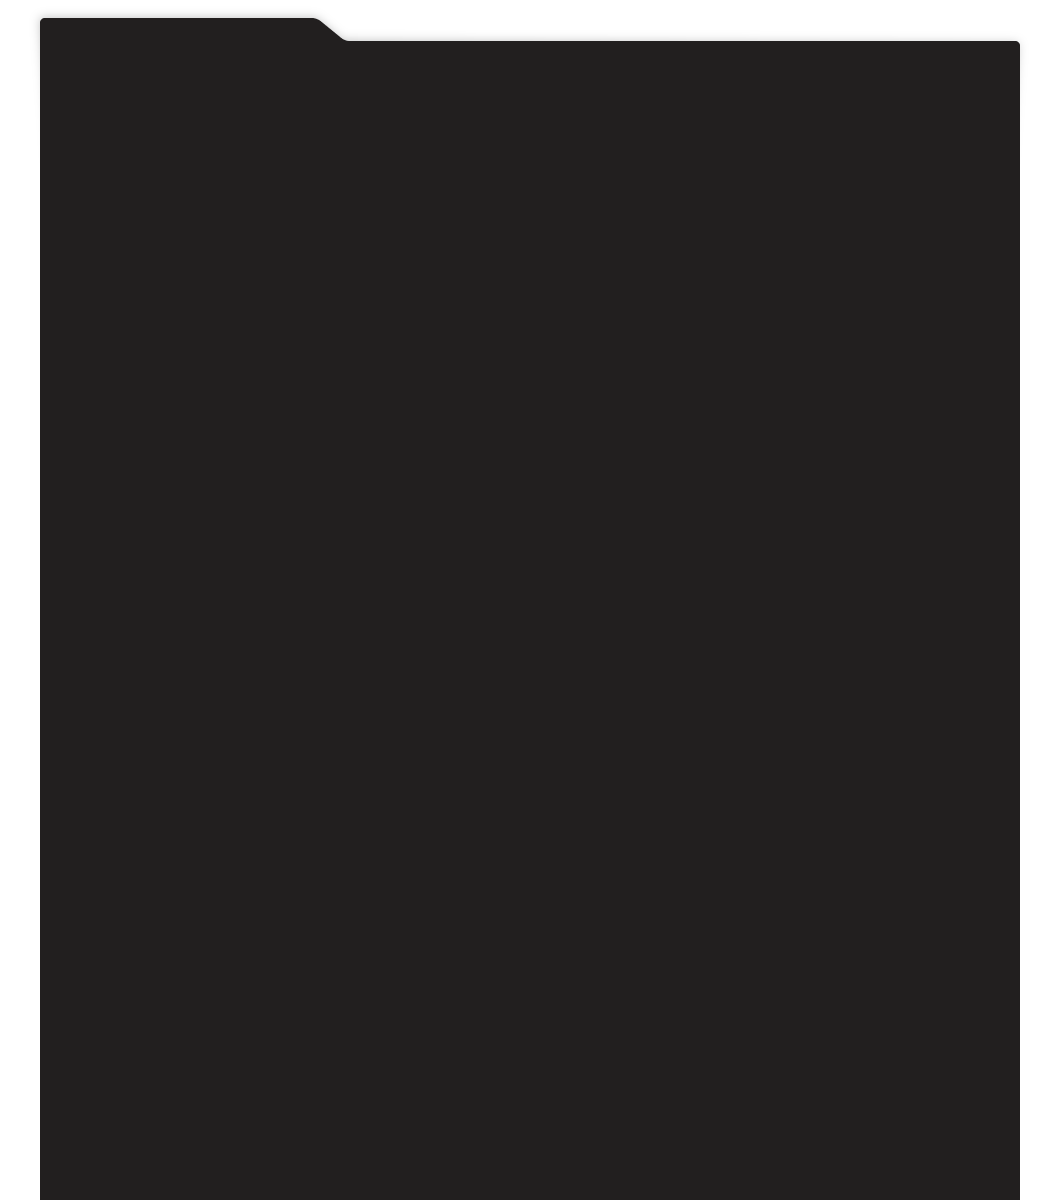
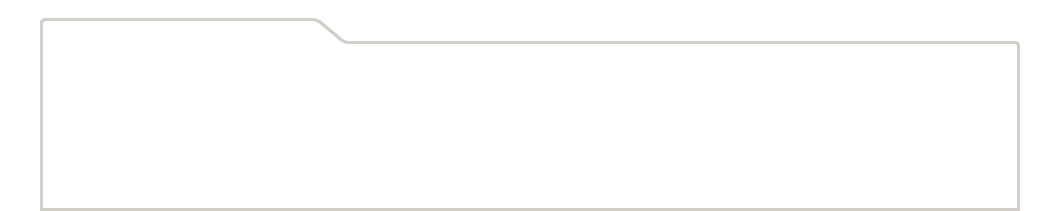
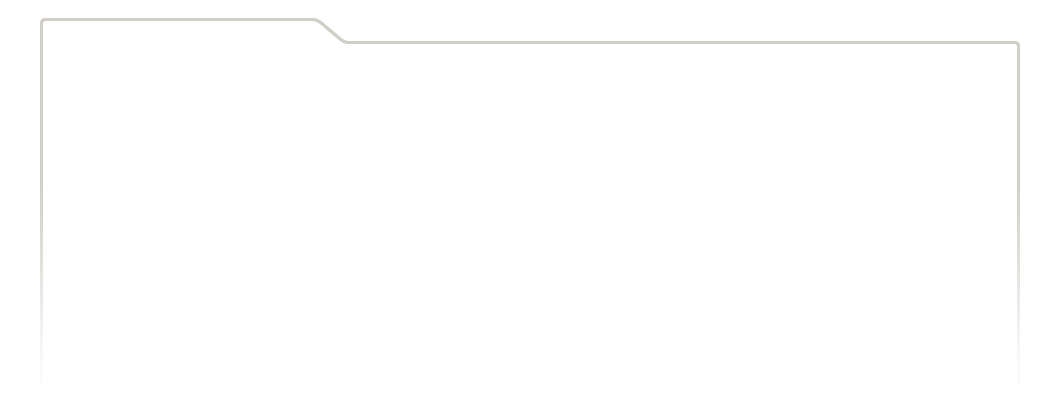
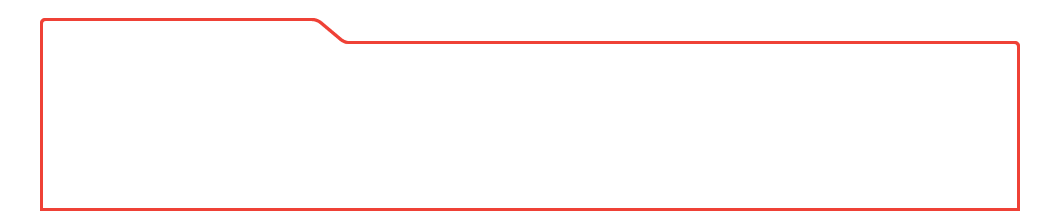
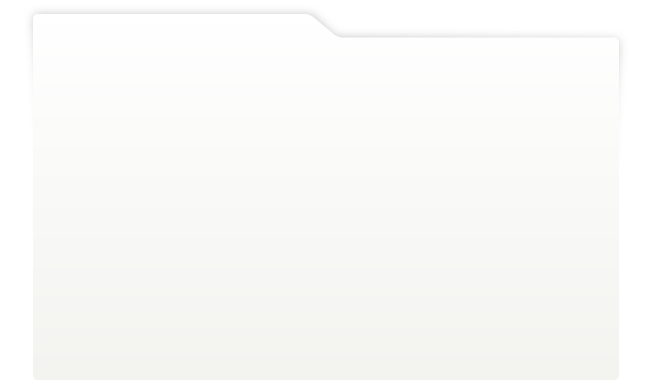
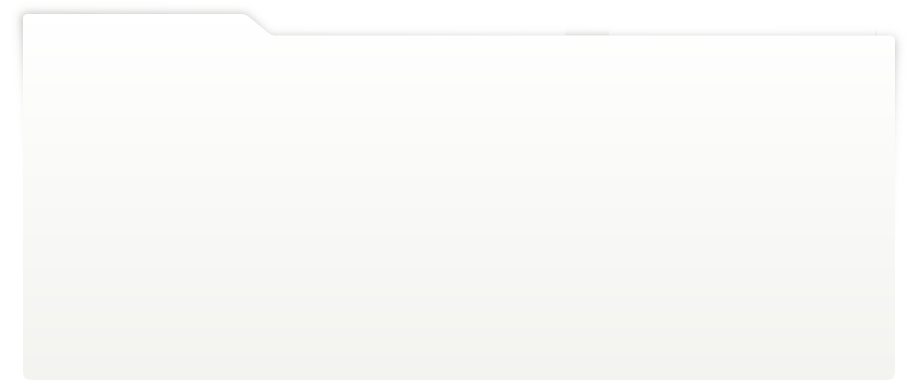
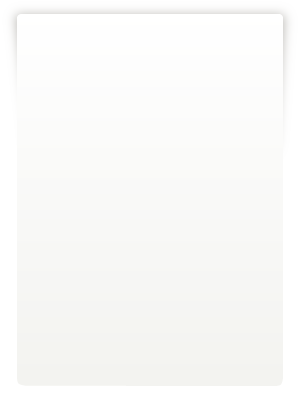
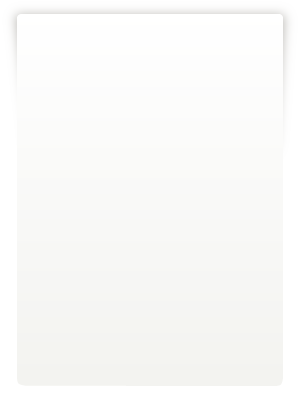
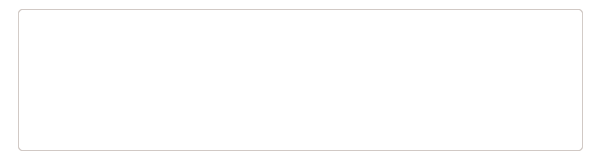
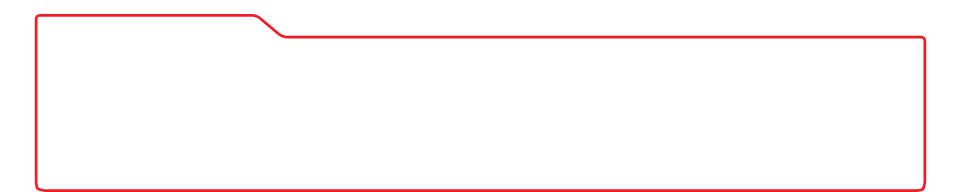
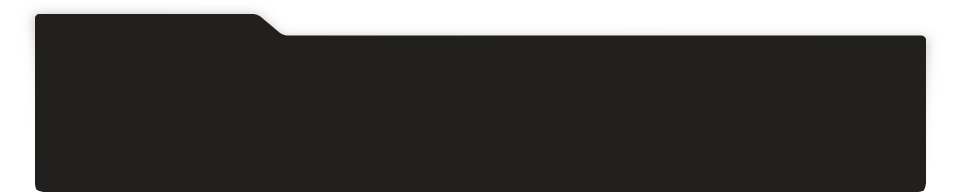
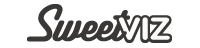
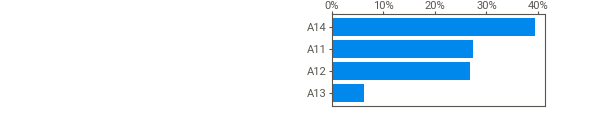
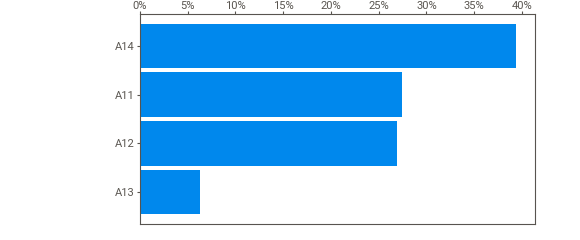
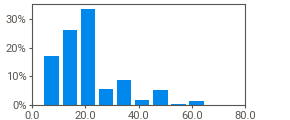
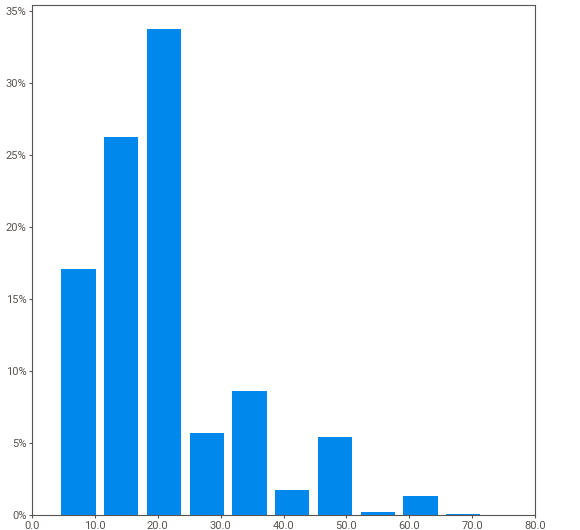
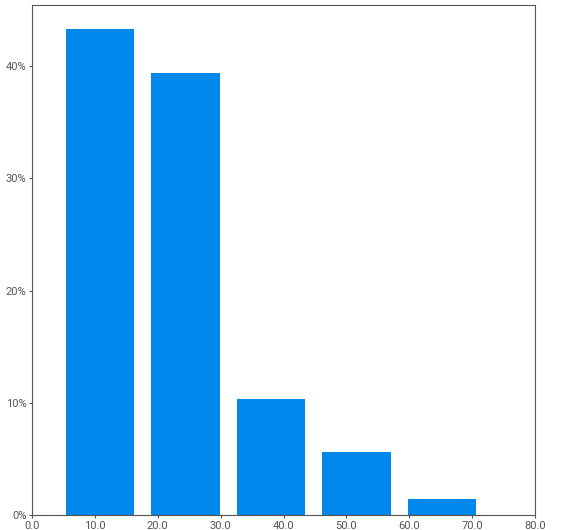
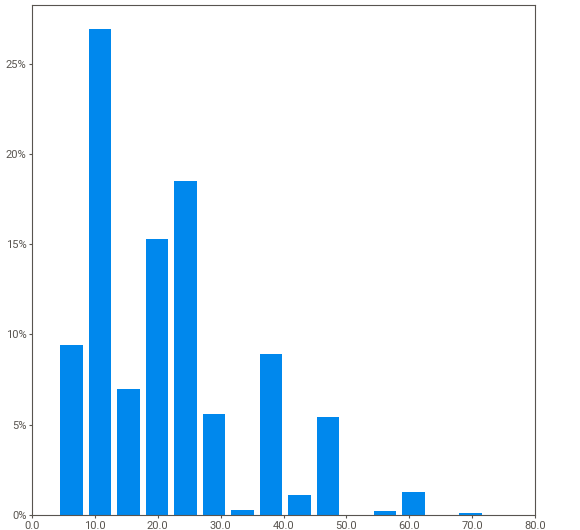
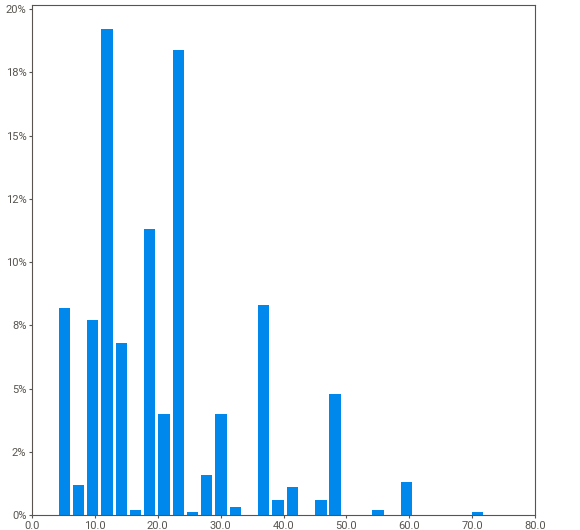
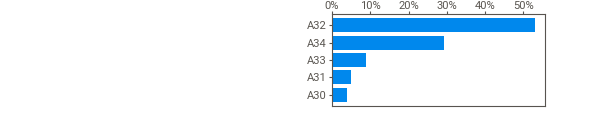
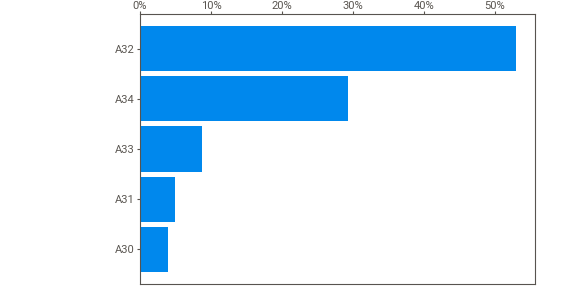
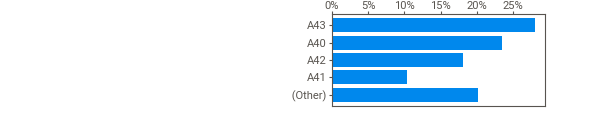
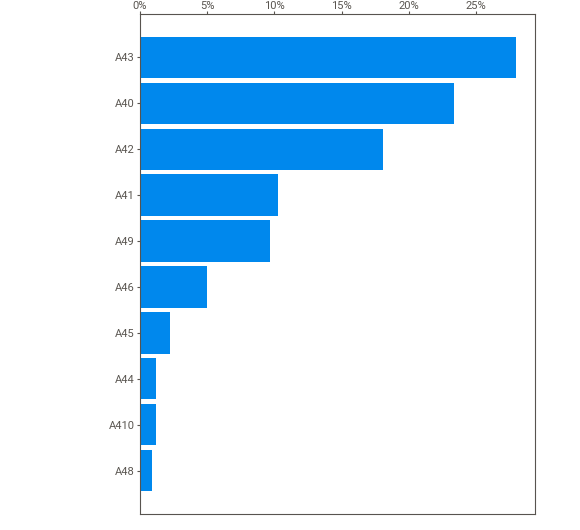
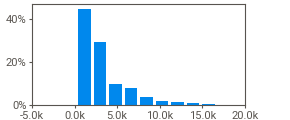
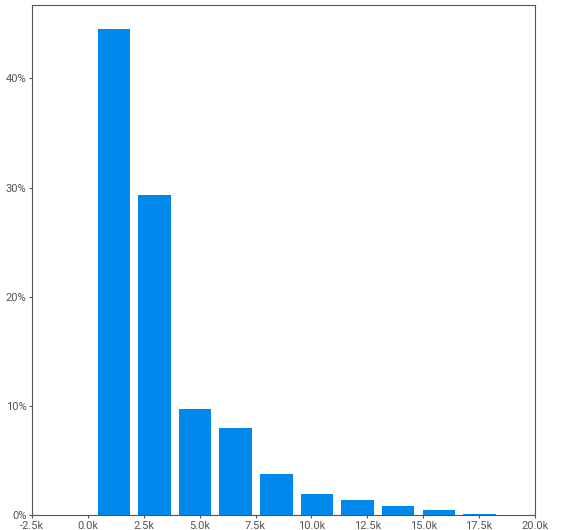
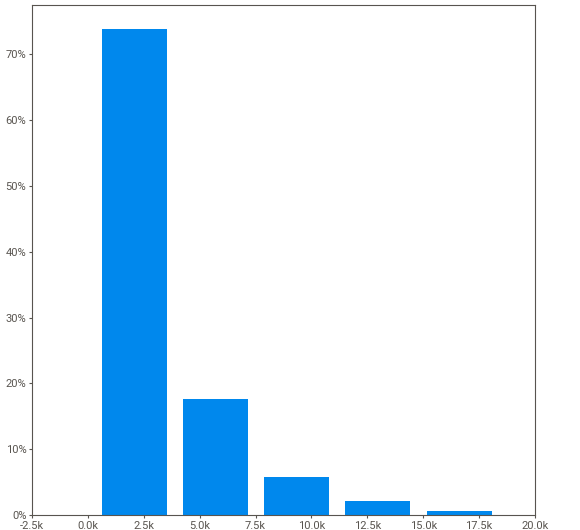
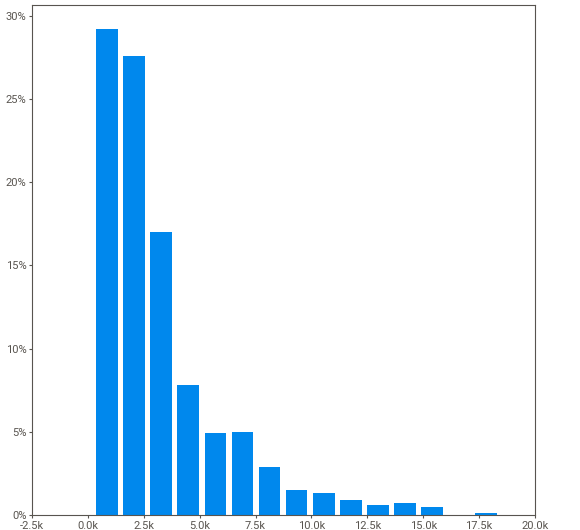
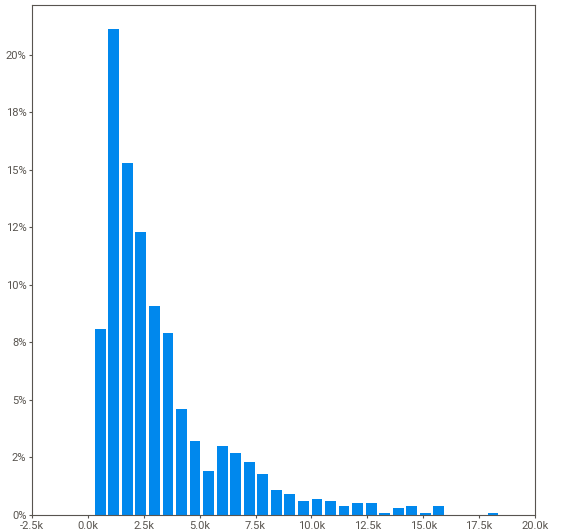
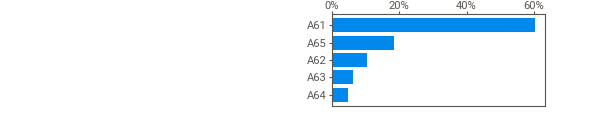
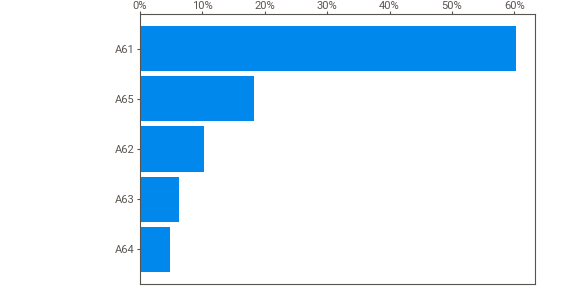
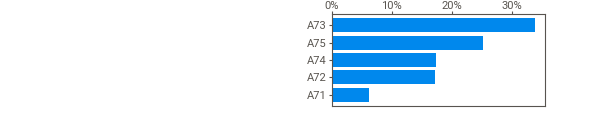
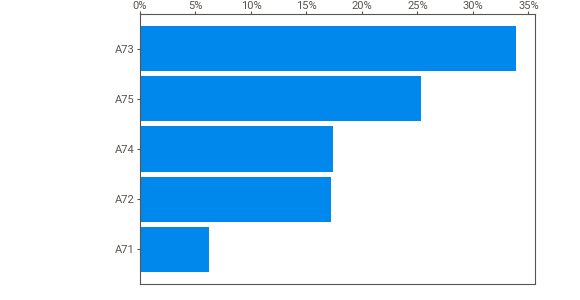
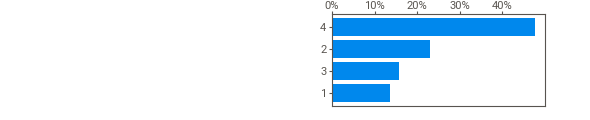
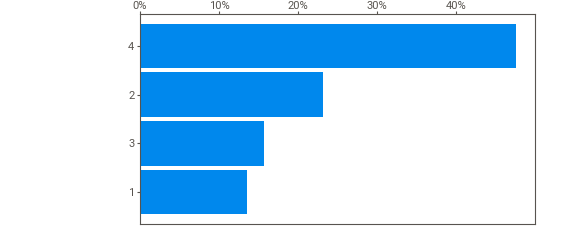
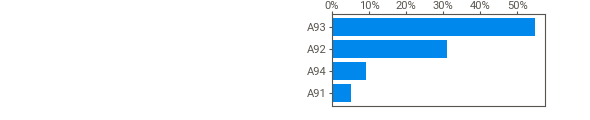
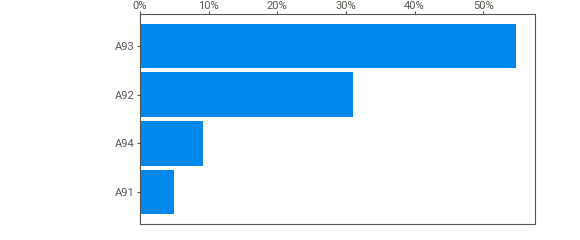
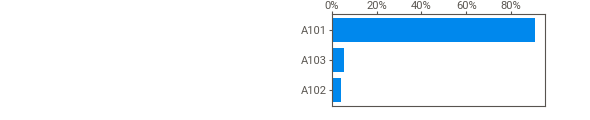
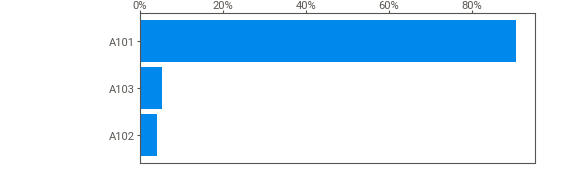
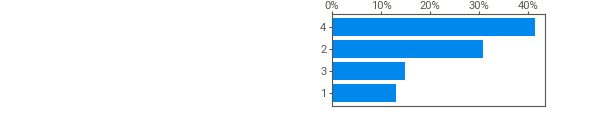
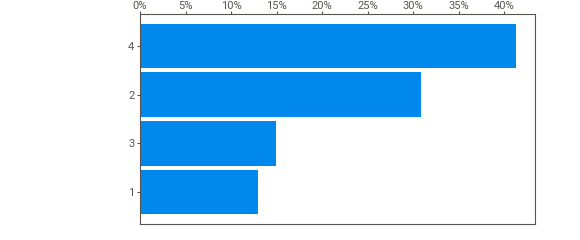
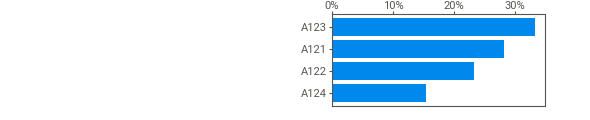
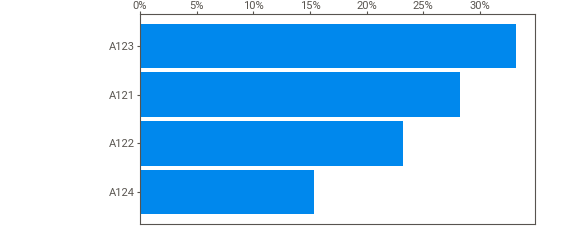
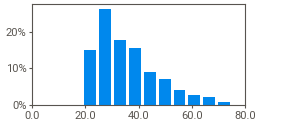
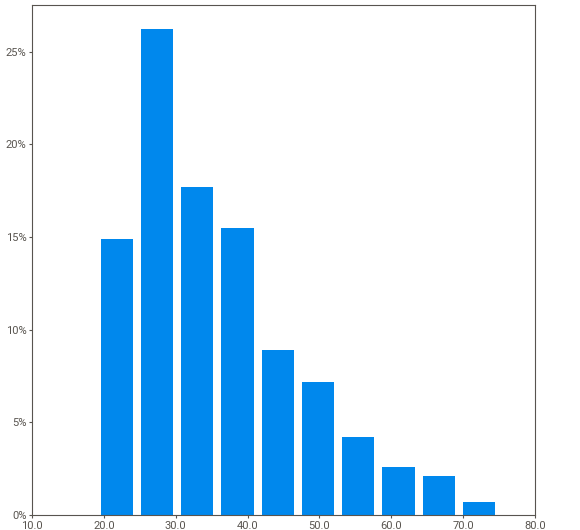
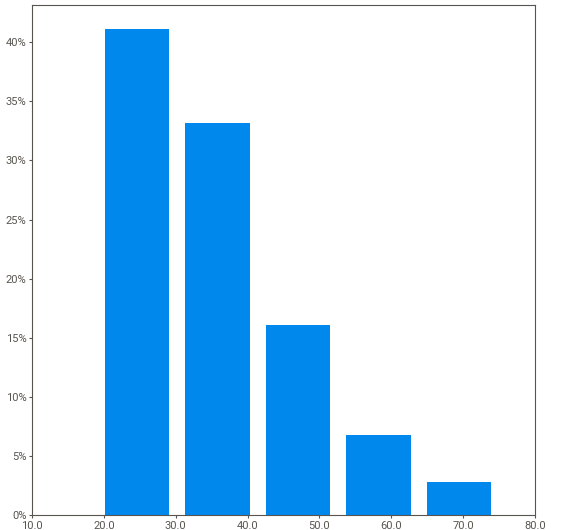
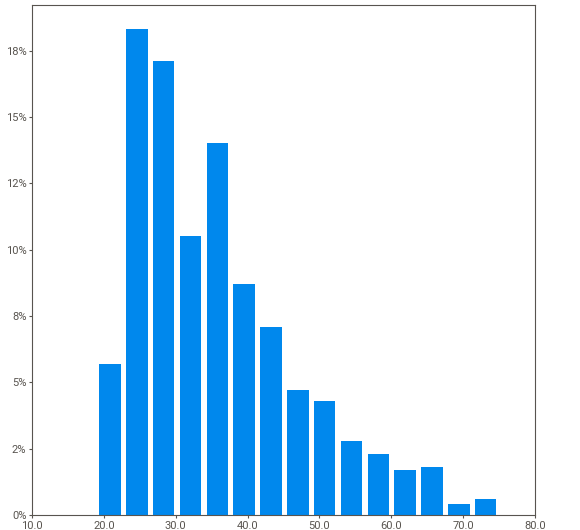
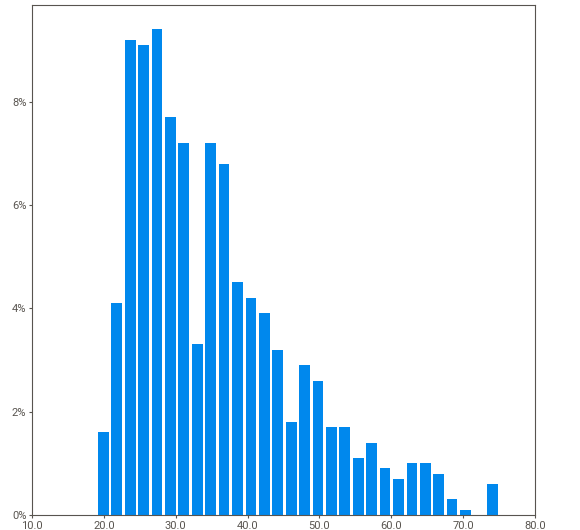
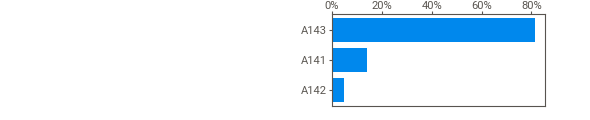
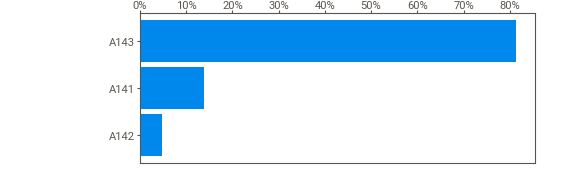
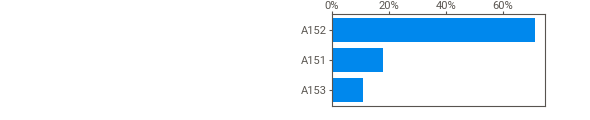
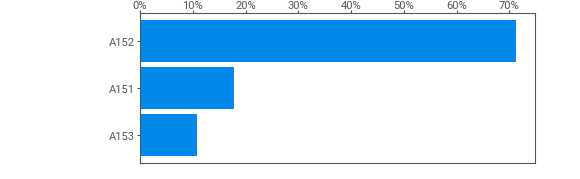
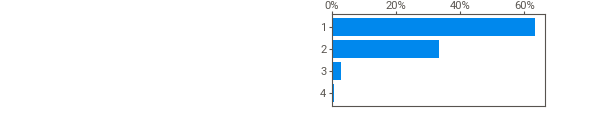
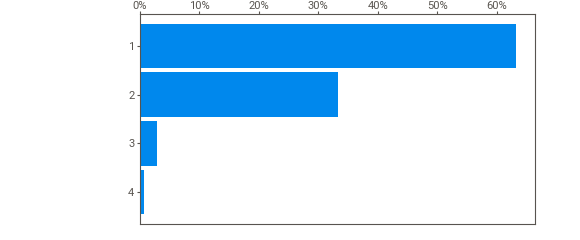
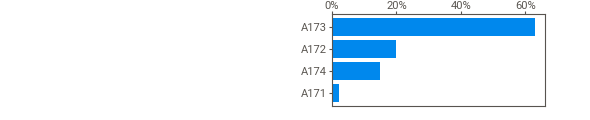
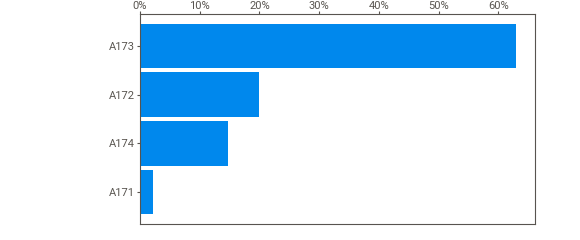
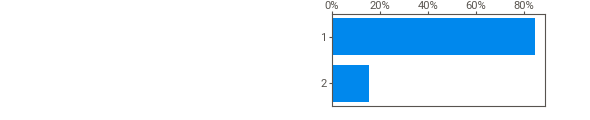
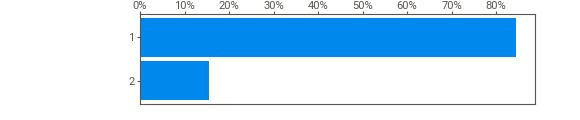
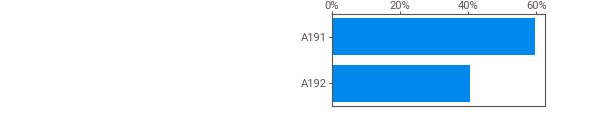
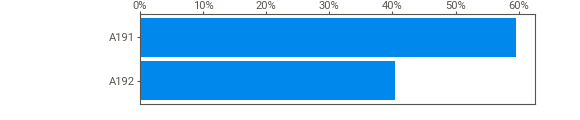
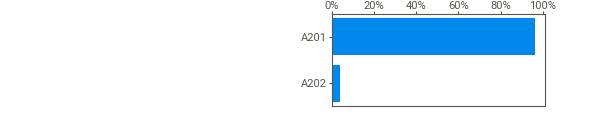
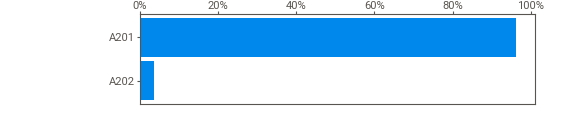
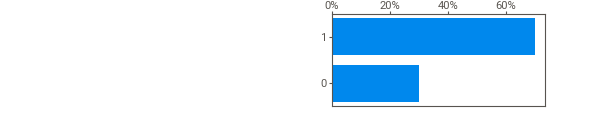
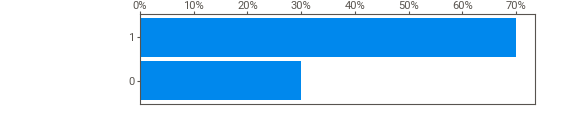
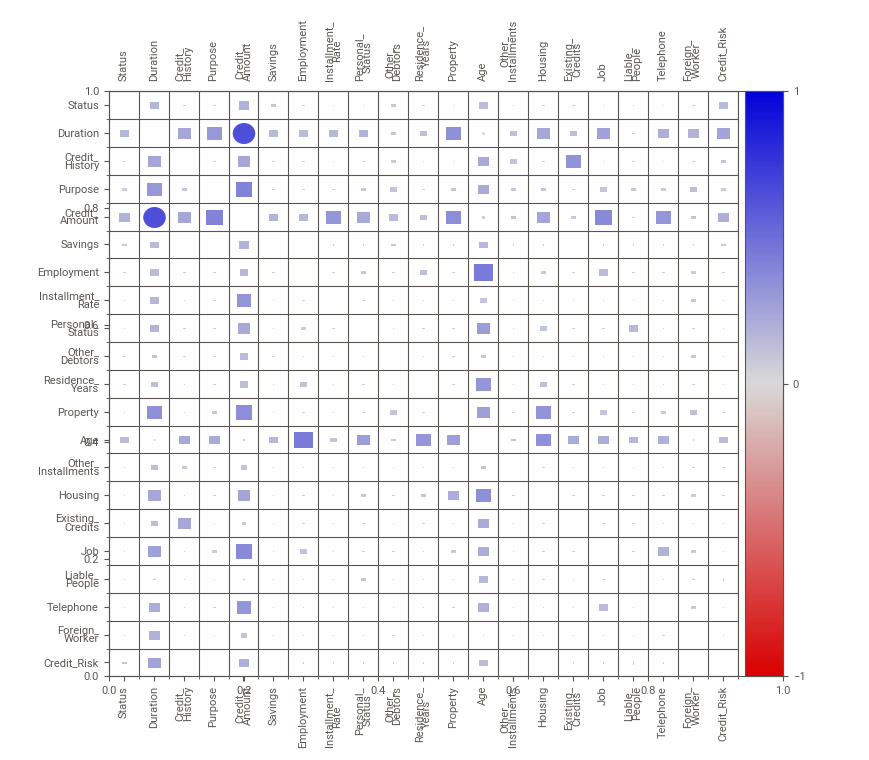
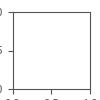

In [6]:
report=sv.analyze(df)
report.show_notebook()

No missing values. Mostly categorical features and a few numerical ones. Not a very large dataset but still decently sized: 1000 observations for 21 features.

In [8]:
# Function to analyze class imbalance
def analyze_class_imbalance(y):
    class_counts = y.value_counts()
    print("Class Distribution:")
    print(class_counts)
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}")
    
    # Create a bar plot showing class distribution
    class_df = pd.DataFrame({
        'Credit_Risk': class_counts.index,
        'Count': class_counts.values
    })
    
    # Lets-plot visualization
    p = ggplot(class_df, aes(x='Credit_Risk', y='Count', fill='Credit_Risk')) + \
        geom_bar(stat='identity') + \
        ggtitle('Class Distribution in German Credit Dataset') + \
        theme_minimal() + \
        scale_fill_discrete() + \
        theme_minimal() +\
        ggsize(1000,600)
    
    p.show()
    
    if imbalance_ratio > 1.5:
        print("The dataset shows class imbalance, justifying the use of balanced metrics.")
    
    return imbalance_ratio > 1.5

analyze_class_imbalance(df.Credit_Risk)

Class Distribution:
Credit_Risk
1    700
0    300
Name: count, dtype: int64
Imbalance Ratio: 2.33


The dataset shows class imbalance, justifying the use of balanced metrics.


True

There are many more customers with bad credit risk than there are with good credit risk.

## ☠️ Part 2: Understanding Data Poisoning

### 🔍 **What is Data Poisoning?** 

Until now, we’ve assumed that our training data is **reliable and representative** of real-world conditions. However, in many real-world scenarios—especially in applications where data is **user-submitted, crowdsourced, or aggregated from external sources**—attackers can intentionally **inject manipulated or misleading samples** into the training dataset to corrupt the model’s performance.  

This attack is called **data poisoning**, a subfield of **adversarial machine learning** that focuses on degrading or biasing the model’s behavior **before** it is deployed.

Data poisoning is a major concern in applications such as:
- **Credit scoring** (e.g., falsifying financial records to influence creditworthiness predictions)
- **Fraud detection** (e.g., injecting fraudulent but labeled-as-legitimate transactions)
- **Spam filtering** (e.g., flooding a spam filter with misleading examples to alter classification)
- **Medical diagnosis AI** (e.g., corrupting datasets to misdiagnose certain conditions)
- **Facial recognition** (e.g., inserting manipulated images to reduce model accuracy)


### **⚠️ How Does Data Poisoning Work?**

An attacker inserts **poisoned data** into the training set, leading the model to learn **incorrect patterns**. This can be done in several ways:

1. **Direct modification of training data** (e.g., altering labels or features).
2. **Indirect manipulation of data sources** (e.g., misleading user-submitted data).
3. **Contaminating streaming data** in online learning models.

### **🛠️ Types of Data Poisoning Attacks**
Data poisoning attacks can be broadly categorized into three types:  

#### **1️⃣ Availability Attacks (Global Degradation)**

- **Goal**: Reduce the overall accuracy of the model, making it unreliable.  
- **Method**: Injecting **random noise**, flipping labels, or modifying feature distributions.  
- **Example**: In a credit scoring model, an attacker modifies hundreds of data points so that the model becomes **unable to distinguish good and bad credit applicants**.  

#### **2️⃣ Integrity Attacks (Targeted Manipulation)**

- **Goal**: Influence the classification of **specific inputs** without significantly affecting the model’s overall accuracy.  
- **Method**: Selectively modifying certain examples, usually ones similar to a target instance.  
- **Example**: A fraudulent individual injects samples where **bad credit applicants are labeled as good**—but does so selectively, so the model still works for most people but misclassifies specific cases.

### **3️⃣ Backdoor Attacks (Hidden Triggers)**

- **Goal**: Embed a **hidden trigger** (a specific pattern) in the training data, which later forces misclassification when the trigger appears.  
- **Method**: Injecting **poisoned samples** with a unique but inconspicuous feature (e.g., a small sticker in an image).  
- **Example**: A bank employee embeds **a specific value in an unrelated feature (e.g., “999” in Age)**, causing all applicants with this value to **automatically be classified as good credit risk**, even if their other financial indicators suggest otherwise.  

### **🎭 Attack Knowledge Levels: White-Box, Gray-Box, and Black-Box**
Different attackers have different levels of knowledge about the model and its training data. This affects how effective the attack can be.  

#### **🟢 White-Box Attacks (Full Knowledge)**

- **Attacker has complete knowledge** of the model, including:
  
  - The training data
  - The feature set
  - The model’s parameters and architecture  
- **Most powerful attack** because the attacker can precisely craft poisoned samples.
- **Example**: A hacker gains access to the bank’s machine learning system and directly modifies the training data, injecting highly optimized poisoned samples.  

#### **🟠 Gray-Box Attacks (Partial Knowledge)**

- The attacker knows **some** information about the model, such as:
  - General structure (e.g., knowing it is a decision tree but not the exact tree)
  - Some of the training data  
- **Less effective than white-box** but still dangerous.
- **Example**: An external fraudster who knows the **types of features** used (e.g., income, credit history) but not the exact model parameters.  

#### **🔴 Black-Box Attacks (No Direct Knowledge)**

- The attacker has **no access** to the model’s internal workings.
- They must rely on **trial and error** by:
  - Submitting examples to observe predictions
  - Guessing which features are important
- **Example**: A cybercriminal applies for loans multiple times with different fabricated financial histories to see which applications get approved, then injects misleading data based on this information.  


### **📝 Summary**

- **Data poisoning** is the process of injecting misleading data into a training set to degrade or manipulate model performance.
- There are **three main types of data poisoning attacks**:
  1. **Availability Attacks**: Aims to make the model unreliable.
  2. **Integrity Attacks**: Focuses on **specific** misclassifications.
  3. **Backdoor Attacks**: Implants hidden triggers that cause incorrect predictions when activated.
- **Attacks differ in knowledge levels**:
  - **White-Box**: Full access to the model and training data.
  - **Gray-Box**: Partial access (e.g., some knowledge of the dataset).
  - **Black-Box**: No direct access, relies on trial and error.  

### **🔍 Real-World Examples of Data Poisoning Attacks**  

| Attack Type | Real-World Example | Impact |
|------------|-----------------|--------|
| **Availability Attack** | **Spam Filters**: Attackers flood an email service with "good" spam emails, making the filter unreliable. | Users receive more spam because the model can’t distinguish spam from legitimate emails. |
| **Integrity Attack** | **Credit Scoring Fraud**: Fraudsters inject fake good-credit profiles into a bank's training data. | The bank grants loans to high-risk individuals, leading to financial losses. |
| **Backdoor Attack** | **Facial Recognition Systems**: Attackers add special stickers to images during training, which later force misclassification when similar stickers appear. | A criminal can wear a specific pair of sunglasses to bypass security checks. |

## 📘 Part 3: Preprocessing and Baseline Models (Training on Clean Data)

Before we see what the impact of data poisoning is on classification models, we need to build baseline models on clean data. But, for that, we first need to pre-process our data. Since there is no missing data, this mainly means encoding categorical variables and scaling numerical ones.

However, different models require different pre-processing steps:

| **Model**             | **Encoding for Categorical Features** | **Scaling of Numerical Features** | **Notes**                                                              |
|-----------------------|--------------------------------------|-----------------------------------|------------------------------------------------------------------------|
| **KNN**               | One-Hot Encoding                     | Yes (StandardScaler)              | Distance-based model; scaling is required.                            |
| **SVM**               | One-Hot Encoding                     | Yes (StandardScaler)              | Distance-based model; scaling is required.                            |
| **Logistic Regression**| One-Hot Encoding                     | Yes (StandardScaler)              | Gradient descent optimization requires scaling.                       |
| **Decision Tree**     | One-Hot Encoding                     | No                                | Tree-based model; no scaling required.                                 |
| **Random Forest**     | One-Hot Encoding                     | No                                | Tree-based model; no scaling required.                                 |
| **XGBoost**           | One-Hot Encoding                     | No                                | Gradient boosting model; no scaling required.                          |
| **LightGBM**          | One-Hot Encoding                     | No                                | Gradient boosting model; no scaling required.                          |
| **CatBoost**          | No explicit encoding (internal handling) | No                                | CatBoost handles categorical features internally; no scaling required. |

- **One-Hot Encoding** is the best option to prevent artificial ordering.
- **CatBoost** automatically handles categorical features and doesn't require **encoding** or **scaling**.


In [9]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Create a copy of the dataset for modifications
df_processed = df.copy()

# Separate target (y) and features (X)
X = df_processed.drop('Credit_Risk', axis=1)
y = df_processed['Credit_Risk']

# --- Preprocessing for KNN, SVM, Logistic Regression (One-Hot Encoding + Scaling) ---
# We will use a ColumnTransformer to handle categorical encoding and scaling

# Define the transformer for categorical and numerical columns
categorical_transformer = OneHotEncoder(sparse_output=False)  # One-Hot Encoding for categorical columns
numerical_transformer = StandardScaler()  # Scaling for numerical columns

# Combine both transformations into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X.select_dtypes(include=['int64', 'float64']).columns),  # Numerical features
        ('cat', categorical_transformer, categorical_cols)  # Categorical features
    ]
)

# Preprocess the features for models requiring scaling and encoding (KNN, SVM, Logistic Regression)
X_scaled_encoded = preprocessor.fit_transform(X)

# Split into training and testing sets (80% train, 20% test) for these models
X_train, X_test, y_train, y_test = train_test_split(X_scaled_encoded, y, test_size=0.2, random_state=42)

# --- Preprocessing for Decision Tree, Random Forest, XGBoost, LightGBM (One-Hot Encoding) ---
# For tree-based models, we will apply One-Hot Encoding for categorical variables, but no scaling is required

# One-Hot Encoding for categorical columns
X_tree_encoded = pd.get_dummies(X, columns=categorical_cols)

# Split into training and testing sets (80% train, 20% test) for tree-based models
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree_encoded, y, test_size=0.2, random_state=42)

# --- Preprocessing for CatBoost (No encoding, no scaling) ---
# CatBoost automatically handles categorical features, so no encoding or scaling is needed

# Prepare data for CatBoost
X_catboost = X.copy()
y_catboost = y.copy()

# Identify categorical columns for CatBoost
catboost_categorical_cols = categorical_cols.tolist()

# Split into training and testing sets (80% train, 20% test) for CatBoost
X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost = train_test_split(
    X_catboost, y_catboost, test_size=0.2, random_state=42
)

# Display the shape of the processed data
print(f"Training data shape (Scaled & Encoded for KNN, SVM, Logistic Regression): {X_train.shape}")
print(f"Test data shape (Scaled & Encoded for KNN, SVM, Logistic Regression): {X_test.shape}")
print(f"Training data shape (Encoded for Tree Models): {X_train_tree.shape}")
print(f"Test data shape (Encoded for Tree Models): {X_test_tree.shape}")
print(f"Training data shape (No encoding or scaling for CatBoost): {X_train_catboost.shape}")
print(f"Test data shape (No encoding or scaling for CatBoost): {X_test_catboost.shape}")

Training data shape (Scaled & Encoded for KNN, SVM, Logistic Regression): (800, 61)
Test data shape (Scaled & Encoded for KNN, SVM, Logistic Regression): (200, 61)
Training data shape (Encoded for Tree Models): (800, 61)
Test data shape (Encoded for Tree Models): (200, 61)
Training data shape (No encoding or scaling for CatBoost): (800, 20)
Test data shape (No encoding or scaling for CatBoost): (200, 20)


Time to train the models!


Training and Evaluating KNN...
KNN - Metrics Summary:
              Metric  Cross-Validation (Training Set)  Test Set
0  Balanced Accuracy                         0.623830  0.635413
1          Precision                         0.761909  0.772455
2             Recall                         0.903443  0.914894
3           F1 Score                         0.826606  0.837662
4                AUC                         0.693640  0.778098
5             AUC PR                         0.693640  0.867740


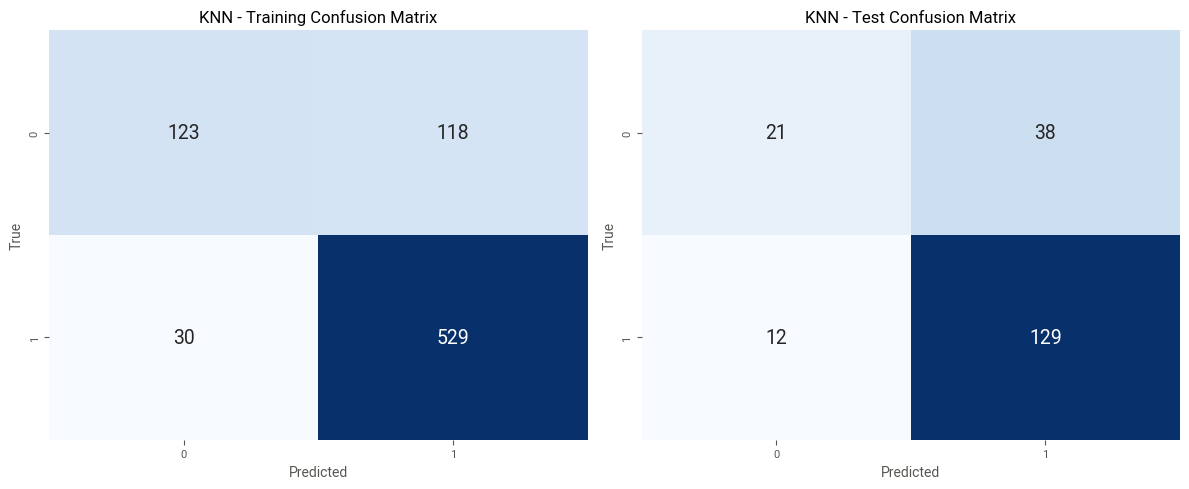


Training and Evaluating SVM...
SVM - Metrics Summary:
              Metric  Cross-Validation (Training Set)  Test Set
0  Balanced Accuracy                         0.630224  0.673639
1          Precision                         0.764210  0.789474
2             Recall                         0.915975  0.957447
3           F1 Score                         0.833084  0.865385
4                AUC                         0.772805  0.810314
5             AUC PR                         0.772805  0.903156


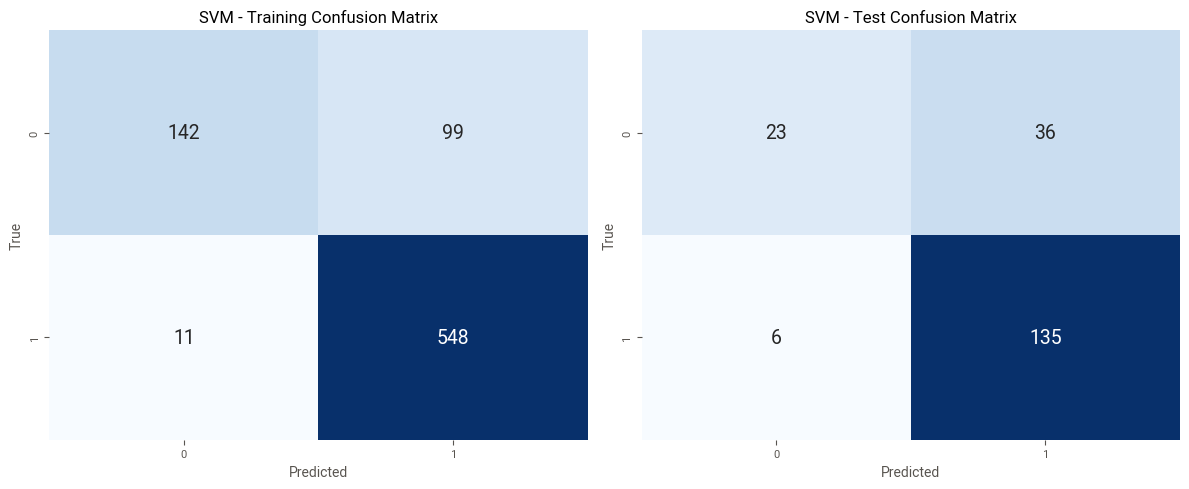


Training and Evaluating Logistic Regression...
Logistic Regression - Metrics Summary:
              Metric  Cross-Validation (Training Set)  Test Set
0  Balanced Accuracy                         0.664545  0.726470
1          Precision                         0.789562  0.828947
2             Recall                         0.864125  0.893617
3           F1 Score                         0.824907  0.860068
4                AUC                         0.770277  0.818368
5             AUC PR                         0.770277  0.908914


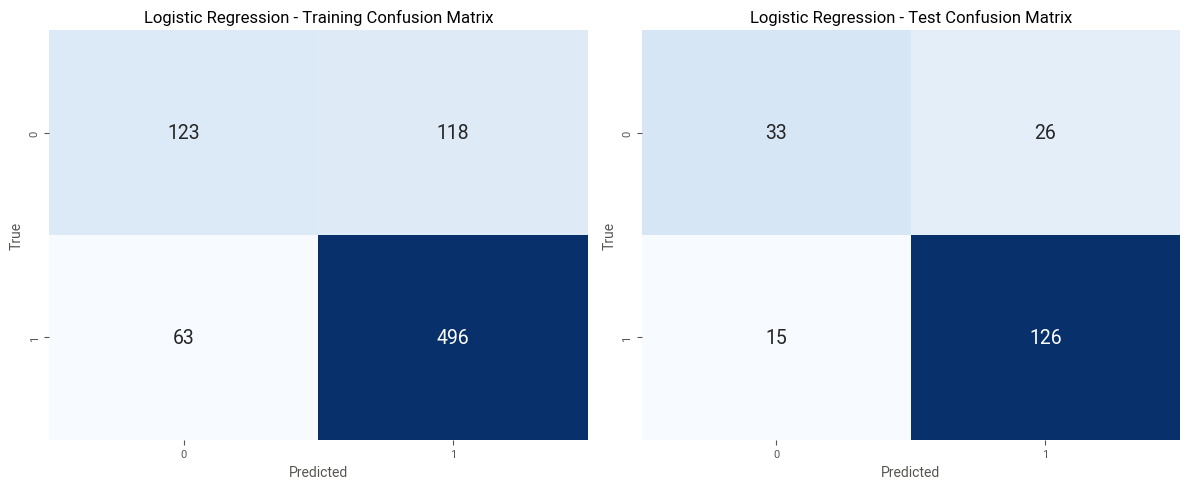


Training and Evaluating Random Forest...
Random Forest - Metrics Summary:
              Metric  Cross-Validation (Training Set)  Test Set
0  Balanced Accuracy                         0.646526  0.703991
1          Precision                         0.774371  0.807229
2             Recall                         0.906998  0.950355
3           F1 Score                         0.835347  0.872964
4                AUC                         0.771337  0.817646
5             AUC PR                         0.771337  0.905580


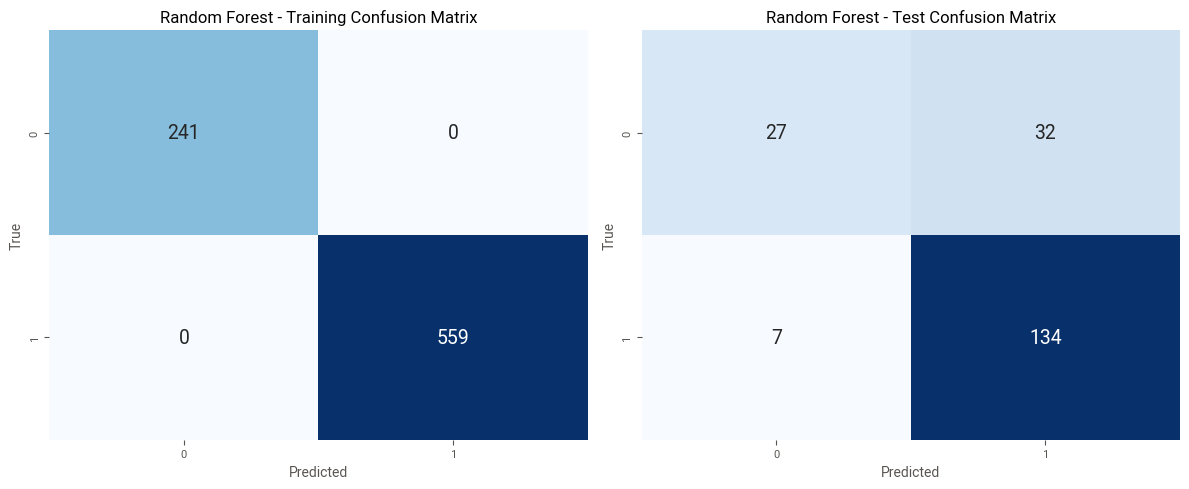


Training and Evaluating XGBoost...
XGBoost - Metrics Summary:
              Metric  Cross-Validation (Training Set)  Test Set
0  Balanced Accuracy                         0.657081  0.717995
1          Precision                         0.787959  0.823529
2             Recall                         0.840862  0.893617
3           F1 Score                         0.812699  0.857143
4                AUC                         0.756365  0.831350
5             AUC PR                         0.756365  0.915383


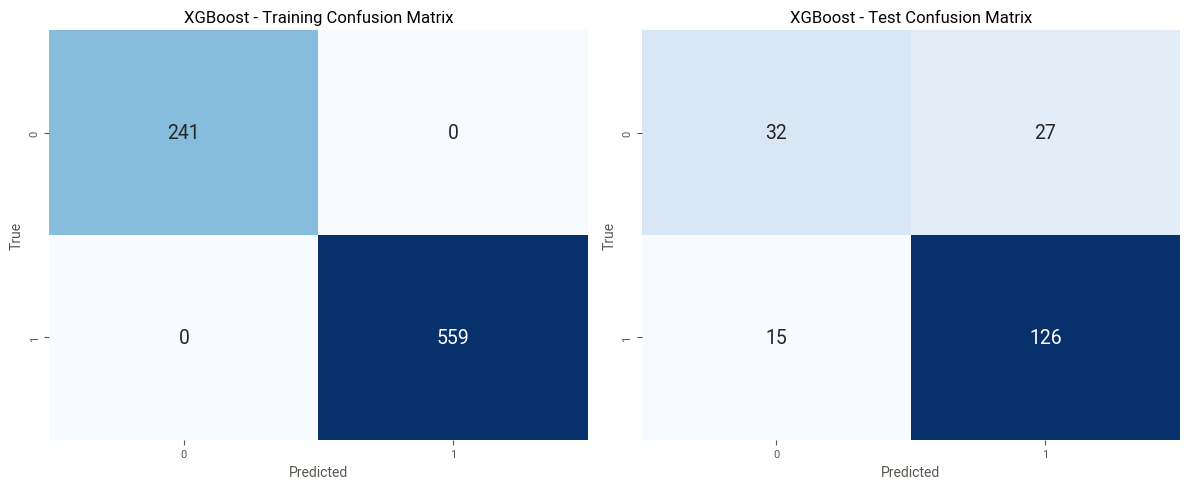


Training and Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 448, number of negative: 192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

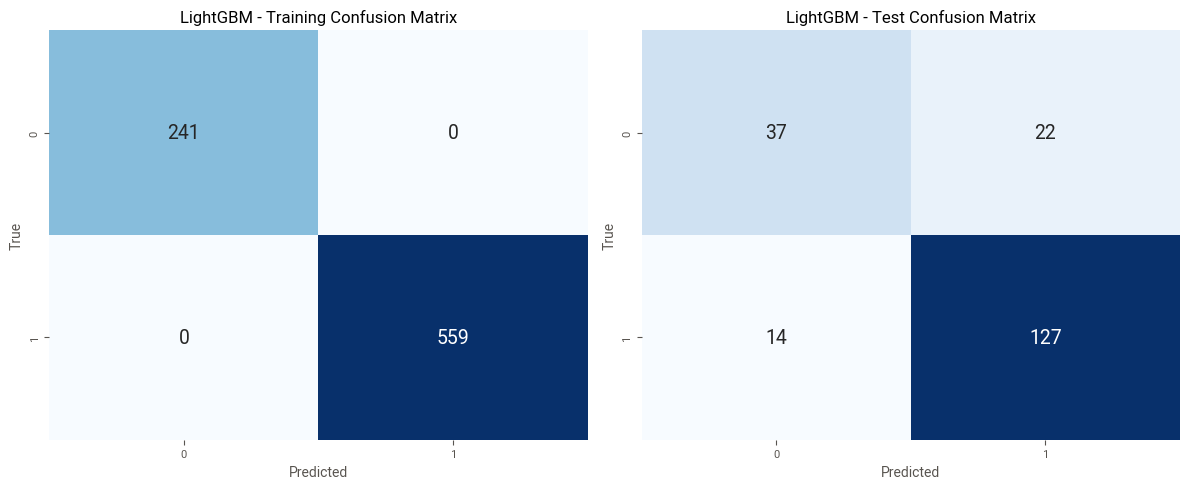


Training and Evaluating CatBoost...
CatBoost - Metrics Summary:
              Metric  Cross-Validation (Training Set)  Test Set
0  Balanced Accuracy                         0.691129  0.679168
1          Precision                         0.804010  0.798742
2             Recall                         0.880132  0.900709
3           F1 Score                         0.840097  0.846667
4                AUC                         0.778933  0.809833
5             AUC PR                         0.778933  0.898334


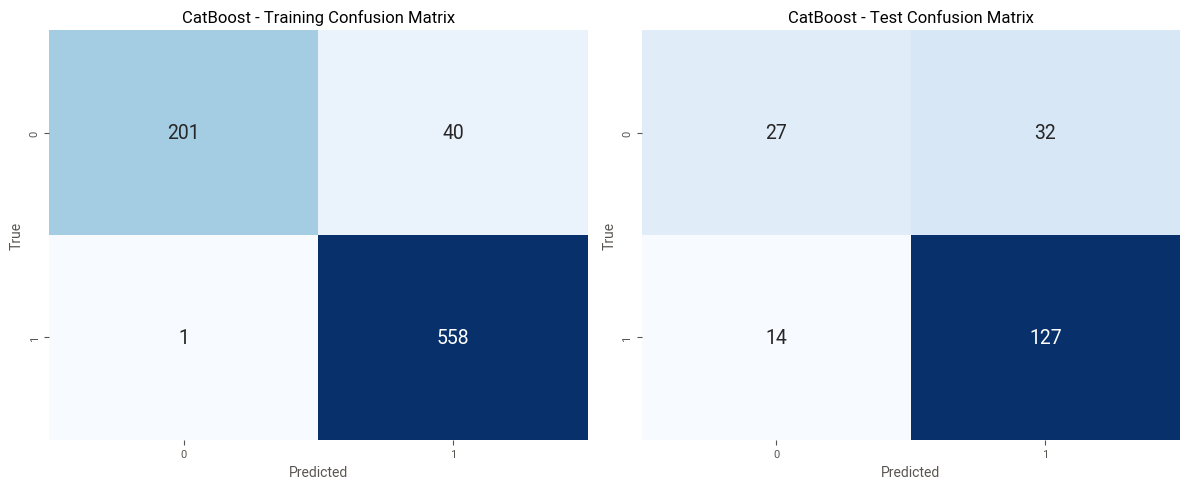

In [10]:
# Define the plotting function for confusion matrices
def plot_confusion_matrix(cm_train, cm_test, model_name):
    # Create subplots for confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap="Blues", ax=axes[0], cbar=False, annot_kws={"size": 14})
    axes[0].set_title(f'{model_name} - Training Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    sns.heatmap(cm_test, annot=True, fmt='d', cmap="Blues", ax=axes[1], cbar=False, annot_kws={"size": 14})
    axes[1].set_title(f'{model_name} - Test Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate models with cross-validation on the training set and metrics on the test set
def train_and_evaluate_model_with_cv(model, X_train, X_test, y_train, y_test, model_name):
    # --- Cross-validation metrics on the training set ---
    scoring = ['balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # --- Train the model on the full training set ---
    model.fit(X_train, y_train)
    
    # --- Test Metrics ---
    y_test_pred = model.predict(X_test)
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC-PR
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
    test_auc_pr = average_precision_score(y_test, y_test_pred_prob)

    # --- Cross-validation mean results ---
    cv_mean_balanced_accuracy = cv_results['test_balanced_accuracy'].mean()
    cv_mean_precision = cv_results['test_precision'].mean()
    cv_mean_recall = cv_results['test_recall'].mean()
    cv_mean_f1 = cv_results['test_f1'].mean()
    cv_mean_roc_auc = cv_results['test_roc_auc'].mean()
    cv_mean_auc_pr = cv_results['test_roc_auc'].mean()  # Using ROC AUC as proxy for AUC PR in CV results
    
    # --- Results Summary ---
    cv_results_summary = pd.DataFrame({
        'Metric': ['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'AUC PR'],
        'Cross-Validation (Training Set)': [
            cv_mean_balanced_accuracy,
            cv_mean_precision,
            cv_mean_recall,
            cv_mean_f1,
            cv_mean_roc_auc,
            cv_mean_auc_pr
        ],
        'Test Set': [
            test_balanced_accuracy,
            test_precision,
            test_recall,
            test_f1,
            test_roc_auc,
            test_auc_pr
        ]
    })

    # Print the summary table
    print(f"{model_name} - Metrics Summary:")
    print(cv_results_summary)
    
    # --- Confusion Matrices for Training and Test Sets ---
    # Training confusion matrix
    cm_train = confusion_matrix(y_train, model.predict(X_train))
    
    # Test confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    # Plot confusion matrices using gggrid
    plot_confusion_matrix(cm_train, cm_test, model_name)

# Initialize the models
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(learning_rate=0.05, iterations=1000, depth=6, loss_function='Logloss', verbose=0,cat_features=catboost_categorical_cols)
}

# Train and evaluate the models with cross-validation and test set evaluation
for model_name, model in models.items():
    print(f"\nTraining and Evaluating {model_name}...")
    # For tree models (, XGBoost, LightGBM) we need the raw (non-scaled) data
    if model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        train_and_evaluate_model_with_cv(model, X_train_tree, X_test_tree, y_train_tree, y_test_tree, model_name)
    elif model_name in ['KNN', 'Logistic Regression', 'SVM']: # For KNN, SVM, Logistic Regression, we use the processed data
        train_and_evaluate_model_with_cv(model, X_train, X_test, y_train, y_test, model_name)
    else:  # remaining case i.e Catboost
        train_and_evaluate_model_with_cv(model, X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost, model_name)


Now that we have our baseline models on clean data, it's time to simulate some data poisoning mechanisms and check their effects!

## Part 4 Data Poisoning simulations

### 4.1 Label flipping

In this type of attack, we randomly flip the labels of a subset of the training data (e.g 0 becomes 1 and vice-versa).

In [19]:
def flip_labels(y, flip_percentage=0.1):
    """Randomly flip labels in the target variable"""
    y_flipped = y.copy()
    n_samples = len(y)
    n_flips = int(flip_percentage * n_samples)
    flip_indices = random.sample(range(n_samples), n_flips)  # Select random indices
    
    # Flip the labels (from 0 to 1 or 1 to 0)
    for idx in flip_indices:
        y_flipped.iloc[idx] = 1 - y_flipped.iloc[idx]
    
    return y_flipped

In [20]:
y_train_poisoned = flip_labels(y_train, flip_percentage=0.1)


In [24]:
# Function to train and evaluate models with or without poisoned data
def train_and_evaluate_with_poisoned_data(model, X_train, X_test, y_train, y_test, poisoned=False):
    """
    Train and evaluate the model, with or without poisoned data (Cross-validation + Metrics)
    """
    
    # --- Cross-validation metrics on the training set ---
    scoring = ['balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc','average_precision']
    
    # Perform cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # --- Train the model on the full training set ---
    model.fit(X_train, y_train)
    
    # Get the predictions for test data
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For AUC-PR calculation
    
    # Calculate performance metrics
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    auc_pr = average_precision_score(y_test, y_pred_prob)
    
    # --- Return results as a dictionary ---
    results = {
        'cv_mean_balanced_accuracy': np.mean(cv_results['test_balanced_accuracy']),
        'cv_mean_precision': np.mean(cv_results['test_precision']),
        'cv_mean_recall': np.mean(cv_results['test_recall']),
        'cv_mean_f1': np.mean(cv_results['test_f1']),
        'cv_mean_roc_auc': np.mean(cv_results['test_roc_auc']),
        'cv_mean_auc_pr': np.mean(cv_results['test_average_precision']),
        'test_balanced_accuracy': balanced_accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_roc_auc': roc_auc,
        'test_auc_pr': auc_pr
    }
    
    return results

In [30]:
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(learning_rate=0.05, iterations=1000, depth=6, loss_function='Logloss', verbose=0,cat_features=catboost_categorical_cols)
}

# Initialize an empty list to store the results for clean and poisoned data
results_clean = []
results_poisoned = []

# Train and evaluate each model on both clean and poisoned data
for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")
    
    
    # Clean data evaluation
        # For tree models (, XGBoost, LightGBM) we need the raw (non-scaled) data
    if model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        results_clean_model = train_and_evaluate_with_poisoned_data(model, X_train_tree, X_test_tree, y_train_tree, y_test_tree, poisoned=False)
        results_clean_model['model'] = model_name
         # Poisoned data evaluation (label flipping + outliers)
        results_poisoned_model = train_and_evaluate_with_poisoned_data(model, X_train_tree, X_test_tree, y_train_poisoned, y_test_tree, poisoned=True)
        results_poisoned_model['model'] = model_name
    elif model_name in ['KNN', 'Logistic Regression', 'SVM']: # For KNN, SVM, Logistic Regression, we use the processed data
        results_clean_model = train_and_evaluate_with_poisoned_data(model, X_train, X_test, y_train, y_test, poisoned=False)
        results_clean_model['model'] = model_name
         # Poisoned data evaluation (label flipping + outliers)
        results_poisoned_model = train_and_evaluate_with_poisoned_data(model, X_train, X_test, y_train_poisoned, y_test, poisoned=True)
        results_poisoned_model['model'] = model_name
    else:  # remaining case i.e Catboost
        results_clean_model = train_and_evaluate_with_poisoned_data(model, X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost, poisoned=False)
        results_clean_model['model'] = model_name
         # Poisoned data evaluation (label flipping + outliers)
        results_poisoned_model = train_and_evaluate_with_poisoned_data(model, X_train_catboost, X_test_catboost, y_train_poisoned, y_test_catboost, poisoned=True)
        results_poisoned_model['model'] = model_name
    # Append results to respective lists
    results_clean.append(results_clean_model)
    results_poisoned.append(results_poisoned_model)

# Convert results to dataframes for clean and poisoned data
df_clean = pd.DataFrame(results_clean)
df_poisoned = pd.DataFrame(results_poisoned)

# Merge the results from clean and poisoned datasets for comparison
df_results_comparison = pd.merge(df_clean, df_poisoned, on="model", suffixes=("_clean", "_poisoned"))

# Metrics with the correct column prefixes ('cv_mean_' and 'test_')
metrics = ['balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'auc_pr']

# Create an empty list to store reshaped data
reshaped_results = []

# Loop through the metrics and add clean and poisoned data for each model
for metric in metrics:
    row = {
        'Metric': metric
    }
    
    for model_name in models.keys():
        # For clean data
        row[f'{model_name}_clean'] = df_results_comparison.loc[df_results_comparison['model'] == model_name, f'cv_mean_{metric}_clean'].values[0]
        row[f'{model_name}_test_clean'] = df_results_comparison.loc[df_results_comparison['model'] == model_name, f'test_{metric}_clean'].values[0]
        
        # For poisoned data
        row[f'{model_name}_poisoned'] = df_results_comparison.loc[df_results_comparison['model'] == model_name, f'cv_mean_{metric}_poisoned'].values[0]
        row[f'{model_name}_test_poisoned'] = df_results_comparison.loc[df_results_comparison['model'] == model_name, f'test_{metric}_poisoned'].values[0]
    
    reshaped_results.append(row)

# Convert the list of rows into a dataframe
df_final_results = pd.DataFrame(reshaped_results)

# Set the Metric column as the index for better display
df_final_results.set_index('Metric', inplace=True)

# Display the final table
df_final_results



Evaluating model: KNN

Evaluating model: SVM

Evaluating model: Logistic Regression

Evaluating model: Random Forest

Evaluating model: XGBoost

Evaluating model: LightGBM
[LightGBM] [Info] Number of positive: 448, number of negative: 192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

KNN_clean  KNN_test_clean  KNN_poisoned  KNN_test_poisoned  \
Metric                                                                          
balanced_accuracy   0.623830        0.635413      0.592554           0.657291   
precision           0.761909        0.772455      0.708106           0.785276   
recall              0.903443        0.914894      0.872381           0.907801   
f1                  0.826606        0.837662      0.781509           0.842105   
roc_auc             0.693640        0.778098      0.610857           0.764695   
auc_pr              0.802107        0.867740      0.713337           0.855043   

                   SVM_clean  SVM_test_clean  SVM_poisoned  SVM_test_poisoned  \
Metric                                                                          
balanced_accuracy   0.630224        0.673639      0.596277           0.670093   
precision           0.764210        0.789474      0.707475           0.788235   
recall              0.915975        0.957447      0.916190           0.950355   
f1                  0.833084        0.865385      0.798220           0.861736   
roc_auc             0.772805        0.810374      0.682182           0.781103   
auc_pr              0.882995        0.903147      0.801167           0.873439   

                   Logistic Regression_clean  Logistic Regression_test_clean  \
Metric                                                                         
balanced_accuracy                   0.664545                        0.726470   
precision                           0.789562                        0.828947   
recall                              0.864125                        0.893617   
f1                                  0.824907                        0.860068   
roc_auc                             0.770277                        0.818368   
auc_pr                              0.885738                        0.908914   

                   ...  XGBoost_poisoned  XGBoost_test_poisoned  \
Metric             ...                                            
balanced_accuracy  ...          0.628571               0.658493   
precision          ...          0.736411               0.797203   
recall             ...          0.817143               0.808511   
f1                 ...          0.773908               0.802817   
roc_auc            ...          0.658459               0.748287   
auc_pr             ...          0.766531               0.865944   

                   LightGBM_clean  LightGBM_test_clean  LightGBM_poisoned  \
Metric                                                                      
balanced_accuracy        0.655091             0.763914           0.612208   
precision                0.785621             0.852349           0.725577   
recall                   0.853378             0.900709           0.817143   
f1                       0.817052             0.875862           0.768221   
roc_auc                  0.762001             0.825099           0.655792   
auc_pr                   0.873909             0.898617           0.767500   

                   LightGBM_test_poisoned  CatBoost_clean  \
Metric                                                      
balanced_accuracy                0.684698        0.691129   
precision                        0.809524        0.804010   
recall                           0.843972        0.880132   
f1                               0.826389        0.840097   
roc_auc                          0.749609        0.778933   
auc_pr                           0.857783        0.877696   

                   CatBoost_test_clean  CatBoost_poisoned  \
Metric                                                      
balanced_accuracy             0.679168           0.600519   
precision                     0.798742           0.714085   
recall                        0.900709           0.862857   
f1                            0.846667           0.780176   
roc_auc                       0.809833           0.681974   
auc_pr    

What do you think will happen if the proportion of labels flipped increases?

## 4.2 Outlier injection

The idea here is to introduce outliers to the dataset and evaluate how the model performance changes compared to the baseline performance on clean data: to do so, we pick a subset of the data (e.g., 5% or 10%) and modify the feature values by adding large deviations, essentially turning them into outliers. We will then train models on the original clean data and on the data with injected outliers and compare their metrics (balanced accuracy, precision, recall, F1 score, ROC AUC, and AUC PR).

In [39]:
def inject_outliers(X, percentage=0.05, factor=10):
    """Injects outliers into numerical columns only."""
    X_outliers = X.copy()

    if isinstance(X_outliers, pd.DataFrame):
        # Identify only numeric columns (exclude one-hot encoded categorical features)
        numeric_cols = X_outliers.select_dtypes(include=['int64', 'float64']).columns
        n_outliers = int(X_outliers.shape[0] * percentage)

        # Randomly pick rows to modify
        outlier_indices = np.random.choice(X_outliers.index, size=n_outliers, replace=False)
        
        # Apply outliers only to numeric columns
        X_outliers.loc[outlier_indices, numeric_cols] *= factor  
    else:
        # If it's a NumPy array, apply outliers to all columns
        n_outliers = int(X_outliers.shape[0] * percentage)
        outlier_indices = np.random.choice(np.arange(X_outliers.shape[0]), size=n_outliers, replace=False)
        X_outliers[outlier_indices] *= factor  

    return X_outliers

Let's train models (with injected outliers) once again!

In [46]:
# Modify train_and_evaluate_with_poisoned_data to handle outliers
def train_and_evaluate_with_outliers(model, X_train, X_test, y_train, y_test, poisoned=False, outliers=False):
    """
    Trains and evaluates a model with optional data poisoning (outliers).
    """
    if outliers:
        X_train = inject_outliers(X_train)
        X_test = inject_outliers(X_test)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on both training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Compute the metrics
    metrics = {
        'balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'roc_auc': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'auc_pr': average_precision_score(y_train, model.predict_proba(X_train)[:, 1])
    }
    
    # Store the metrics in a dictionary
    results = {f'cv_mean_{metric}_train': value for metric, value in metrics.items()}
    
    # Repeat for test set
    metrics_test = {
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'auc_pr': average_precision_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    
    results.update({f'test_{metric}_test': value for metric, value in metrics_test.items()})
    
    return results

# Define models as before
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(learning_rate=0.05, iterations=1000, depth=6, loss_function='Logloss', verbose=0, cat_features=catboost_categorical_cols)
}

# Initialize lists to store results
results_clean = []
results_outliers = []

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")
    
    # Clean data evaluation
    if model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        results_clean_model = train_and_evaluate_with_outliers(model, X_train_tree, X_test_tree, y_train_tree, y_test_tree, poisoned=False, outliers=False)
        results_clean_model['model'] = model_name
        
        results_outliers_model = train_and_evaluate_with_outliers(model, X_train_tree, X_test_tree, y_train_tree, y_test_tree, poisoned=False, outliers=True)
        results_outliers_model['model'] = model_name
    elif model_name in ['KNN', 'Logistic Regression', 'SVM']:
        results_clean_model = train_and_evaluate_with_outliers(model, X_train, X_test, y_train, y_test, poisoned=False, outliers=False)
        results_clean_model['model'] = model_name
        
        results_outliers_model = train_and_evaluate_with_outliers(model, X_train, X_test, y_train, y_test, poisoned=False, outliers=True)
        results_outliers_model['model'] = model_name
    else:  # For CatBoost
        results_clean_model = train_and_evaluate_with_outliers(model, X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost, poisoned=False, outliers=False)
        results_clean_model['model'] = model_name
        
        results_outliers_model = train_and_evaluate_with_outliers(model, X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost, poisoned=False, outliers=True)
        results_outliers_model['model'] = model_name

    # Append results for clean and outliers data
    results_clean.append(results_clean_model)
    results_outliers.append(results_outliers_model)

# Convert results to dataframes for clean and outliers data
df_clean = pd.DataFrame(results_clean)
df_outliers = pd.DataFrame(results_outliers)

# Merge the results from clean and outlier datasets for comparison
df_results_comparison_outlier = pd.merge(df_clean, df_outliers, on="model", suffixes=("_clean", "_outliers"))

# Display the results comparison (sort by the correct column)
df_results_comparison_outlier.sort_values(by="cv_mean_balanced_accuracy_train_clean", ascending=False, inplace=True)

# Reshape the results as before for the final table
metrics = ['balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'auc_pr']
reshaped_results_outlier = []

# Loop through the metrics and add clean and outliers data for each model
for metric in metrics:
    row = {'Metric': metric}
    
    for model_name in models.keys():
        # For clean data
        row[f'{model_name}_clean'] = df_results_comparison_outlier.loc[df_results_comparison_outlier['model'] == model_name, f'cv_mean_{metric}_train_clean'].values[0]
        row[f'{model_name}_test_clean'] = df_results_comparison_outlier.loc[df_results_comparison_outlier['model'] == model_name, f'test_{metric}_test_clean'].values[0]
        
        # For outlier data
        row[f'{model_name}_outliers'] = df_results_comparison_outlier.loc[df_results_comparison_outlier['model'] == model_name, f'cv_mean_{metric}_train_outliers'].values[0]
        row[f'{model_name}_test_outliers'] = df_results_comparison_outlier.loc[df_results_comparison_outlier['model'] == model_name, f'test_{metric}_test_outliers'].values[0]
    
    reshaped_results_outlier.append(row)

# Convert the list of rows into a dataframe
df_final_results_outlier = pd.DataFrame(reshaped_results_outlier)

# Set the Metric column as the index for better display
df_final_results_outlier.set_index('Metric', inplace=True)

# Display the final table
df_final_results_outlier




Evaluating model: KNN

Evaluating model: SVM

Evaluating model: Logistic Regression

Evaluating model: Random Forest

Evaluating model: XGBoost

Evaluating model: LightGBM
[LightGBM] [Info] Number of positive: 559, number of negative: 241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698750 -> initscore=0.841353
[LightGBM] [Info] Start training from score 0.841353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

KNN_clean  KNN_test_clean  KNN_outliers  KNN_test_outliers  \
Metric                                                                          
balanced_accuracy   0.728353        0.635413      0.720663           0.625556   
precision           0.817620        0.772455      0.812214           0.766082   
recall              0.946333        0.914894      0.951699           0.929078   
f1                  0.877280        0.837662      0.876442           0.839744   
roc_auc             0.873373        0.778098      0.871989           0.765236   
auc_pr              0.922719        0.867740      0.922306           0.854237   

                   SVM_clean  SVM_test_clean  SVM_outliers  SVM_test_outliers  \
Metric                                                                          
balanced_accuracy   0.784767        0.673639      0.580304           0.555776   
precision           0.846986        0.789474      0.734478           0.729167   
recall              0.980322        0.957447      0.994633           0.992908   
f1                  0.908789        0.865385      0.844985           0.840841   
roc_auc             0.949536        0.810434      0.841451           0.791682   
auc_pr              0.975656        0.903189      0.920099           0.891573   

                   Logistic Regression_clean  Logistic Regression_test_clean  \
Metric                                                                         
balanced_accuracy                   0.698836                        0.726470   
precision                           0.807818                        0.828947   
recall                              0.887299                        0.893617   
f1                                  0.845695                        0.860068   
roc_auc                             0.830091                        0.818368   
auc_pr                              0.918448                        0.908914   

                   ...  XGBoost_outliers  XGBoost_test_outliers  \
Metric             ...                                            
balanced_accuracy  ...               1.0               0.727852   
precision          ...               1.0               0.832215   
recall             ...               1.0               0.879433   
f1                 ...               1.0               0.855172   
roc_auc            ...               1.0               0.817166   
auc_pr             ...               1.0               0.903515   

                   LightGBM_clean  LightGBM_test_clean  LightGBM_outliers  \
Metric                                                                      
balanced_accuracy             1.0             0.763914                1.0   
precision                     1.0             0.852349                1.0   
recall                        1.0             0.900709                1.0   
f1                            1.0             0.875862                1.0   
roc_auc                       1.0             0.825099                1.0   
auc_pr                        1.0             0.898617                1.0   

                   LightGBM_test_outliers  CatBoost_clean  \
Metric                                                      
balanced_accuracy                0.691790        0.916118   
precision                        0.812081        0.933110   
recall                           0.858156        0.998211   
f1                               0.834483        0.964564   
roc_auc                          0.789157        0.989415   
auc_pr                           0.893110        0.994634   

                   CatBoost_test_clean  CatBoost_outliers  \
Metric                                                      
balanced_accuracy             0.679168           0.916118   
precision                     0.798742           0.933110   
recall                        0.900709           0.998211   
f1                            0.846667           0.964564   
roc_auc                       0.809833           0.986795   
auc_pr    

## Part 5 Mitigation strategies


| **Defense Strategy** | **Attack Types** | **How It Works** | **Effectiveness** | **German Credit Suitability** | **Suitability Explanation** | **Applicable Models** | **Implementation Notes** |
|----------------------|------------------|------------------|-------------------|------------------------------|----------------------------|------------------------|--------------------------|
| **Cross-Validation** | Both | Uses multiple splits of data to train and evaluate models, ensuring each point is used in training and validation. Reduces overfitting due to noisy data. | **High** – Handles up to **30%** of label flips or outliers without issues. | High | The moderate size of German Credit (1000 samples) makes cross-validation highly effective as each fold still contains sufficient data. The class imbalance is also well-handled by stratified CV. | **All models** | Use 5-fold stratified CV to maintain class distribution across folds. |
| **Robust Loss Functions** | Label Flipping / Outliers | Modifies the loss function (e.g., Hinge, Huber) to reduce the impact of outliers and label flips by down-weighting their contribution to the loss. | **Up to 10-20%** – Effective for **small to moderate** amounts of label flips or outliers. | Medium | German Credit has both categorical and numerical features with varying scales, making robust loss functions moderately effective. Most helpful for numeric features like credit amount and duration. | **Logistic Regression, SVM, XGBoost, LightGBM** | For LogReg, use `class_weight='balanced'`. For XGBoost, use `scale_pos_weight` parameter. |
| **Robust SVM** | Label Flipping | Uses a modified version of the SVM that introduces a penalty on misclassified outliers, making the model robust to label flips. | **Up to 30-40%** – Works well for moderate label flipping but performance degrades above 40%. | High | The mixed feature types and moderate dimensionality of German Credit make SVM with proper regularization highly effective. The dataset's decision boundary complexity is well-captured by SVM kernels. | **SVM** | Use RBF kernel with `C=0.1` and `class_weight='balanced'` to handle class imbalance. |
| **Outlier Detection Techniques** | Outliers | Identifies outliers based on density or decision tree splits, treating them as less important in the final model prediction. | **Up to 30%** – Effectiveness decreases as outlier proportion exceeds 30%. | High | German Credit contains both categorical and numerical features where anomalies are detectable. Economic variables like income, credit amount, and duration benefit greatly from outlier detection. | **KNN, Random Forest, XGBoost, LightGBM** | Apply Isolation Forest to numerical features; use one-hot encoding for categorical features first. |
| **Random Forest (Bagging)** | Both | Ensemble method where multiple decision trees are trained on bootstrapped subsets of data. Bagging reduces variance and is inherently robust to noise and outliers. | **Up to 30-40%** – Works well with moderate levels of label flips or outliers. | High | The mixture of categorical and numerical features in German Credit is handled naturally by Random Forest. The bootstrapping helps with the moderate class imbalance in the dataset. | **Random Forest** | Use 500+ trees with `max_samples=0.7` to increase diversity and robustness against poisoning. |
| **Outlier Detection in Random Forest** | Outliers | Identifies data points that appear rarely across trees in a Random Forest model, which are flagged as outliers. | **Up to 30%** – Effective with **low to moderate** proportions of outliers. | High | Random Forest path analysis works well on German Credit's mixed feature set, detecting unusual combinations of financial variables that may indicate poisoning. | **Random Forest** | Track samples appearing in leaf nodes < 5% of trees; these are likely poisoned samples. |
| **Isolation Forest** | Outliers | Uses random decision trees to isolate outliers; the fewer splits needed to isolate a point, the more likely it is an outlier. | **Up to 30%** – Very effective for moderate to high proportions of outliers (10-30%). | High | Particularly effective for German Credit's numerical features like credit amount, age, and duration where outliers are easier to isolate through random partitioning. | **All models** | Set `contamination=0.1` for German Credit as a preprocessing step before modeling. |
| **MCD (Minimum Covariance Determinant)** | Outliers | Detects outliers in multivariate data by minimizing the covariance matrix's determinant, making it less sensitive to large outliers. | **Up to 30%** – Effective for **moderate outlier levels** in high-dimensional settings. | Medium | Somewhat effective for German Credit's continuous variables, but less useful for categorical features which make up a significant portion of the dataset. | **Logistic Regression, XGBoost, LightGBM** | Apply only to the subset of numerical features after standardization. |
| **Label Smoothing** | Label Flipping | Slightly adjusts label values (e.g., flips labels with a small probability), reducing the impact of label flipping. | **Up to 10%** – Effective for **small amounts** of label flips (up to ~10%). | Medium | Limited effectiveness due to the binary nature of the German Credit target variable (good/bad risk). Works better with multi-class problems or regression tasks. | **Logistic Regression, Neural Networks** | Can be implemented by adjusting positive class probability from 1.0 to 0.9. |
| **Ensemble Methods (Boosting, Bagging)** | Both | Combines multiple models to reduce the variance and bias in predictions, which improves performance under data poisoning attacks. | **Up to 40-50%** – Effective for **higher levels** of noise (label flips or outliers). | High | The diverse feature set in German Credit benefits from ensemble approaches that can capture different aspects of the data. Class imbalance is also well-handled by weighted ensembles. | **XGBoost, LightGBM, Random Forest, CatBoost** | Combine SVM, Random Forest, and XGBoost with weighted voting based on cross-validated performance. |
| **Gradient Boosting with Built-In Robustness** | Both | Uses boosting with built-in regularization or loss functions designed to be more resilient to outliers and label flipping. | **Up to 30%** – Effective with moderate levels but performance degrades beyond 30%. | High | German Credit's mix of feature types and moderate dimensionality is well-suited for gradient boosting. Regularization parameters can be tuned to address specific poisoning vulnerabilities in the dataset. | **XGBoost, LightGBM, CatBoost** | For XGBoost, use `max_delta_step=1` and `min_child_weight=5` to reduce vulnerability to outliers. |
| **Data Preprocessing (Cleaning and Transformation)** | Both | Techniques such as feature scaling, normalization, and imputation can reduce the impact of outliers and noise in the data before training. | **Up to 20%** – Effective with smaller amounts of noise, less effective for high levels. | Medium | Moderately effective for German Credit due to mixed feature types. Scaling helps with numerical features, but preprocessing categorical features is more challenging. | **All models** | Scale numerical features with RobustScaler; use quantile-based binning for features like credit amount. |
| **Weight Clipping or Re-weighting** | Label Flipping | Adjusts weights of samples during training, focusing more on those that are consistently misclassified, which can help mitigate the impact of label flips. | **Up to 20%** – Useful for handling **moderate levels** of label flipping but not for higher proportions. | High | Very effective for German Credit due to its class imbalance. Re-weighting helps prevent the majority class (good credit) from overwhelming the minority class when poisoning occurs. | **Logistic Regression, XGBoost, LightGBM** | Dynamically adjust sample weights inversely proportional to prediction confidence during iterative training. |


#### What are robust loss functions?

**Robust loss functions** are a class of loss functions designed to reduce the impact of noisy or anomalous data points—such as flipped labels or injected outliers—during model training. These loss functions are less sensitive to extreme values compared to traditional loss functions (like the standard **mean squared error** or **logistic loss**), making them more resistant to the influence of incorrect or noisy labels and outliers.

##### **Why Use robust loss functions?**

In machine learning, especially in classification tasks, models are often highly sensitive to outliers or mislabeled data. These problematic data points can lead to overfitting and poor generalization. Robust loss functions help mitigate this by applying less weight to outliers and noisy labels during training. They achieve this by modifying how the error is penalized.

##### **Common Robust Loss Functions**:

Sure! Here's a redrafted version of the table with the formulas for each robust loss function, providing a clear explanation of their goals and which models they apply to:

1. **Hinge Loss**:
   - **Goal**: Hinge loss is used primarily in Support Vector Machines (SVM) to create a margin of separation between classes. It penalizes misclassifications based on their distance from the decision boundary, making it robust to noisy labels when they are far from the boundary.
   - **Formula**:
     $$
     L(y, \hat{y}) = \max(0, 1 - y \cdot \hat{y})
     $$
     Where:
     - $y$ is the true label (either +1 or -1),
     - $\hat{y}$ is the predicted score (before applying a threshold).
   - **Applicable Models**: **SVM**

2. **Log-Cosh Loss**:
   - **Goal**: Log-Cosh loss is a smoother approximation of the mean squared error (MSE), making it less sensitive to outliers. It is particularly useful for mitigating the effect of noisy labels in logistic regression.
   - **Formula**:
     $$
     L(y, \hat{y}) = \log(\cosh(\hat{y} - y))
     $$
     Where:
     - $y$ is the true label,
     - $\hat{y}$ is the predicted probability or logit (before sigmoid).
   - **Applicable Models**: **Logistic Regression**

3. **Focal Loss (Robust Cross-Entropy)**:
   - **Goal**: Focal Loss modifies the standard cross-entropy loss to focus more on hard-to-classify examples, thus reducing the impact of well-classified examples and mitigating the effect of noisy labels, especially in class-imbalanced datasets.
   - **Formula**:
     $$
     L(y, \hat{y}) = -\alpha (1 - \hat{y})^\gamma \log(\hat{y})
     $$
     Where:
     - $y$ is the true label (0 or 1),
     - $\hat{y}$ is the predicted probability for class 1,
     - $\alpha$ is a balancing factor for class imbalance,
     - $\gamma$ is the focusing parameter to down-weight easy examples.
   - **Applicable Models**: **XGBoost**, **LightGBM**, **CatBoost**

4. **Bootstrap Aggregating (Bagging)**:
   - **Goal**: Bagging (Bootstrap Aggregating) is not a loss function but a technique that trains multiple models on random subsets of the training data. By averaging the predictions, it helps reduce variance and makes the model more robust to outliers.
   - **Formula** (for a prediction $ \hat{y} $ from an ensemble of models $ m $):
     $$
     \hat{y}_{\textrm{final}} = \frac{1}{M} \sum_{i=1}^{M} \hat{y}_i
     $$
     Where:
     - $ M $ is the number of base models,
     - $\hat{y}_i$ is the prediction from the $i$-th model.
   - **Applicable Models**: **Random Forest** (inherent in the model)

5. **Pruning and Robust Splitting Criteria**:
   - **Goal**: Decision trees can use robust splitting criteria (e.g., entropy, Gini impurity) and pruning methods to reduce sensitivity to outliers. Pruning prevents the tree from growing too deep, thus avoiding overfitting and making the model more resilient to noise.
   - **Formula for Gini Impurity** (used in Decision Trees):
     $$
     Gini(t) = 1 - \sum_{i=1}^{C} p_i^2
     $$
     Where:
     - $t$ is a node,
     - $p_i$ is the proportion of class $ i $ in node $ t $,
     - $C$ is the number of classes.
   - **Applicable Models**: **Decision Trees** (and **Random Forest**)

Ah, I see! You're referring to **Tukey's Bi-weight** loss function, which is often used in robust statistics. Thanks for pointing that out! Let me update the information accordingly.


6. **Tukey Bi-weight Loss**  
- **Goal**: **Tukey Bi-weight loss** is a robust loss function that reduces the influence of outliers by applying a weight to residuals that decreases as the residual increases. The loss grows quadratically for small residuals and then flattens out for larger residuals, effectively minimizing the impact of large outliers.
  
- **Formula**:  
  $$
  L(y, \hat{y}) = \begin{cases}
  \left(\hat{y} - y\right)^2, & \textrm{if } |\hat{y} - y| \leq c \\
  \frac{c^2}{6} \left[ 1 - \left( \frac{|\hat{y} - y|}{c} \right)^2 \right]^3, & \textrm{if} |\hat{y} - y| > c
  \end{cases}
  $$
  Where:
  - $y$ is the true label,
  - $\hat{y}$ is the predicted value (before applying a threshold),
  - $c$ is a constant that controls the threshold, often chosen to limit the influence of outliers.

- **Applicable Models**: **Logistic Regression**, **XGBoost**, **LightGBM**, **CatBoost**, and other models that are designed to handle noisy data robustly.

7. **Cauchy Loss**
   - **Goal**: **Cauchy loss** is a robust loss function inspired by the Cauchy distribution. It behaves similarly to the Huber loss but assigns a smaller weight to large residuals. This makes it effective at reducing the impact of outliers in both regression and classification tasks.
   - **Formula**:
    $$
     L(y, \hat{y}) = \log\left( 1 + \left(\frac{\hat{y} - y}{\gamma}\right)^2 \right)
    $$
     Where:
     - $y$ is the true label,
     - $\hat{y}$ is the predicted value (before applying a threshold),
     - $\gamma$ is a scale parameter that controls the sensitivity to residuals (typically chosen based on the data).
   - **Applicable Models**: **XGBoost**, **LightGBM**, **CatBoost**, **Logistic Regression** (especially useful when noisy labels are present).

<br/>

**Summary of common robust loss functions**

<table border="1" cellpadding="10" cellspacing="0">
    <thead>
        <tr>
            <th><strong>Robust Loss Function</strong></th>
            <th><strong>Goal</strong></th>
            <th><strong>Formula</strong></th>
            <th><strong>Applicable Models</strong></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><strong>Hinge Loss</strong></td>
            <td>Creates a margin of separation, penalizes misclassifications.</td>
            <td>L(y, ŷ) = max(0, 1 - y ⋅ ŷ)</td>
            <td><strong>SVM</strong></td>
        </tr>
        <tr>
            <td><strong>Log-Cosh Loss</strong></td>
            <td>Smooth approximation of squared error, robust to outliers.</td>
            <td>L(y, ŷ) = log(cosh(ŷ - y))</td>
            <td><strong>Logistic Regression</strong></td>
        </tr>
        <tr>
            <td><strong>Focal Loss (Robust Cross-Entropy)</strong></td>
            <td>Focuses on hard-to-classify examples, down-weights easy examples.</td>
            <td>L(y, ŷ) = -α(1 - ŷ)^γ log(ŷ)</td>
            <td><strong>XGBoost, LightGBM, CatBoost</strong></td>
        </tr>
        <tr>
            <td><strong>Bootstrap Aggregating (Bagging)</strong></td>
            <td>Reduces variance by training on random subsets and averaging predictions.</td>
            <td>ŷfinal = (1/M) Σ(ŷi)</td>
            <td><strong>Random Forest (inherent)</strong></td>
        </tr>
        <tr>
            <td><strong>Pruning & Robust Splitting Criteria</strong></td>
            <td>Limits tree complexity to avoid overfitting, reducing sensitivity to outliers.</td>
            <td>Gini(t) = 1 - Σ(pᵢ)^2</td>
            <td><strong>Decision Trees, Random Forest</strong></td>
        </tr>
        <tr>
            <td><strong>Tukey Bi-weight Loss</strong></td>
            <td>Handles small residuals quadratically and large residuals with a constant loss.</td>
            <td>
                L(y, ŷ) = <br> 
                <strong>if |ŷ - y| ≤ c:</strong> (ŷ - y)² <br>
                <strong>if |ŷ - y| > c:</strong> (c²/6) * (1 - (|ŷ - y|/c)²)³
            </td>
            <td><strong>Logistic Regression, XGBoost, LightGBM, CatBoost</strong></td>
        </tr>
        <tr>
            <td><strong>Cauchy Loss</strong></td>
            <td>Reduces the influence of large residuals, robust to outliers.</td>
            <td>L(y, ŷ) = log(1 + ((ŷ - y)/γ)²)</td>
            <td><strong>XGBoost, LightGBM, CatBoost, Logistic Regression</strong></td>
        </tr>
    </tbody>
</table>


##### **When to Use Robust Loss Functions?**

- **Label Flipping**: In the case of label flipping, when a few data points are assigned incorrect labels, robust loss functions can help mitigate the impact of those points by reducing the penalty on misclassified instances.
  - **Example**: If a point with a flipped label is misclassified, using **Huber loss** will reduce the penalty compared to the regular log-loss function, preventing the model from being heavily influenced by this incorrect label.
  
- **Outlier Injection**: For outliers, robust loss functions can significantly reduce the influence of outliers by applying smaller penalties to instances where the error is large. This helps prevent the model from fitting to extreme, unrepresentative data points.
  - **Example**: If outliers are injected into the training data, **Tukey’s Bi-weight loss** or **Cauchy loss** would limit their impact by assigning less weight to these extreme data points during training.

##### **Practical Application in our models**:

- **Logistic Regression**: When using logistic regression, applying robust loss functions like **Log-Cosh loss** or **Cauchy loss** can help mitigate the impact of label flipping or small outliers.
  
- **KNN**: For KNN, the loss function is typically not defined explicitly, but **distance-based weighting** can be used to mitigate outlier effects.

- **SVM**: **Cauchy loss** can be applied in robust versions of SVMs, such as **Nu-SVM** or **Robust SVM**, to reduce the influence of mislabeled points or outliers.

- **Random Forest, XGBoost, LightGBM, CatBoost**: These tree-based models are typically more resistant to outliers, but incorporating regularization and using robust loss functions like Tukey bi-weight loss within the gradient boosting framework can further reduce sensitivity to noise in the training data.

In summary, **robust loss functions** play an essential role in mitigating the influence of noisy labels and outliers in model training by applying reduced penalties to large errors, thus improving the model's robustness and generalization.

#### What is MCD?

MCD (Minimum Covariance Determinant) is a robust method used for outlier detection. It estimates the covariance matrix of the data in such a way that it minimizes the influence of outliers. The basic idea is to compute a robust estimate of the covariance matrix that is not heavily affected by the outliers.

**How it works:** MCD works by finding the subset of the data that best fits a multivariate Gaussian distribution, using the minimum covariance determinant as a criterion. It computes the covariance matrix of this subset and uses it to identify outliers as those points that significantly deviate from the center of the distribution.

**Advantages:**
It provides a robust estimate of the covariance matrix, making it less sensitive to outliers in multivariate datasets.
Particularly effective in high-dimensional datasets where outliers might distort the covariance structure.

**Limitations:**

It can be computationally expensive, especially for large datasets.
Performance may degrade in the presence of very large outliers that significantly impact the covariance structure.

### Key Clarifications on Effectiveness:
1. **Cross-Validation**: The effectiveness remains high as cross-validation ensures that noisy or poisoned data points are distributed across multiple splits and thus not overemphasized in the model's training.
2. **Robust Loss Functions**: These loss functions (e.g., Huber, Hinge) modify the training process to penalize outliers or label flips less severely, which helps when a moderate proportion of data is poisoned.
3. **Robust SVM**: SVM models can tolerate moderate label flipping due to penalty mechanisms that reduce the impact of misclassified data.
4. **Outlier Detection**: Methods like LOF and Isolation Forest are effective when outliers make up **up to 30%** of the data but lose effectiveness if that proportion is higher.
5. **Random Forest (Bagging)**: The inherent bagging of Random Forests helps mitigate the impact of outliers and noise, with good performance even with **up to 30-40%** outliers or flipped labels.
6. **Isolation Forest**: Designed specifically for outliers, it can handle up to **30%** outliers efficiently and is particularly strong in those cases.
7. **Ensemble Methods (Boosting, Bagging)**: Both boosting and bagging methods are powerful in aggregating the results of multiple models, making them resilient to moderate to high levels of noise and outliers, often handling up to **40-50%** noise.
8. **MCD** (): Works particularly well for multivariate data and can handle **up to 30%** outliers in high-dimensional settings.
9. **Weight Clipping**: Useful for controlling the impact of label flips in the loss function, but the technique becomes less effective as the proportion of flipped labels increases beyond **20%**.

